Data visualization and results

In [36]:
###########
# Imports #
###########

# -----------------------------------
# Core Libraries
# -----------------------------------
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------
# Plotting Tools
# -----------------------------------
from matplotlib.ticker import MultipleLocator, PercentFormatter
from adjustText import adjust_text
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp

# -----------------------------------
# Machine Learning / Stats
# -----------------------------------
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
############# 
# plotting  #
#############

# ----------------------------
# Landscape2 plot function
# ----------------------------
def plot_landscape2(df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts=None, y_pts=None, signs=[1, 1], pca_model=None, show=True):
    pca_df, pca_model = do_PCA(df, models, party_codes, pca_model)
    # DO plotting
    make_landscape_plot(pca_df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts, y_pts, signs, show)
    return pca_df, pca_model

# ----------------------------
# PCA plot function
# ----------------------------
def do_PCA(df, models, party_codes, pca_model=None, n_components=2):
    
    columns = party_codes+models
    
    df[columns] = df[columns].fillna(0)
    df[columns] = df[columns].apply(pd.to_numeric)

    df_transposed = df[columns].transpose()
    if pca_model == None:
        pca_model = PCA(n_components=n_components)
        pca_result = pca_model.fit_transform(df_transposed)
    else:
        pca_result = pca_model.transform(df_transposed)
        
    print(len(pca_model.mean_))
    pca_df = pd.DataFrame(data=pca_result, columns=[f'PCA{i+1}' for i in range(pca_result.shape[1])], index=df_transposed.index)
    print(pca_df)
    return pca_df, pca_model

# ----------------------------
# Landscape plot function
# ----------------------------
def make_landscape_plot(pca_df, title, models, exp, party_codes, colors_models, colors_parties, exp_var, x_pts=None, y_pts=None, signs=[1, 1], show=True, xlim=None, ylim=None):
    """
    if exp == "ES":
        colors_parties = [
            "#fdbb84",  # Ciudadanos
            "#31a354",  # Más País
            "#3182bd",  # PNV
            "#de2d26",  # PP
            "#756bb1",  # PSOE
            "#e6550d",  # CUP
            "#636363",  # ERC
            "#bdbdbd",  # VOX
            "#6baed6",  # EH Bildu
            "#9ecae1"   # Junts
        ]
    else:
        # fallback or other country setup (keep if needed)
        colors_parties = ['#D91A39','#3C79C1','#0A8E3E','#18295E','#FC9A2B','#85C046','#B21D62','#064B2F','#701C44','#F75822']
    """
    print(colors_parties)
    print(colors_models)
    colors = colors_parties + colors_models
    
    plt.figure(figsize=(13, 13))

    df_plot = pca_df.copy()
    
    df_plot.iloc[:, 0] = signs[0] * df_plot.iloc[:, 0] 
    df_plot.iloc[:, 1] = signs[1] * df_plot.iloc[:, 1] 
    
    texts = []
    pca_cols = df_plot.columns
    print(pca_cols)
    for idx, col in enumerate(df_plot.index):
        try:
            if idx >= 9+7:
                marker_style = '^'
            elif idx >= len(df_plot.index) - len(models):
                marker_style = '*'
            else:
                marker_style = 'o'  # Default marker style (circle)

            plt.scatter(df_plot.loc[col, pca_cols[0]], df_plot.loc[col, pca_cols[1]], 
                        label=col, s=400, color=colors[idx % len(colors)], marker=marker_style)
            x_offset = 0.02  # Adjust as needed
            y_offset = 0.02  # Adjust as needed
            texts.append(plt.text(df_plot.loc[col, pca_cols[0]] + x_offset, df_plot.loc[col, pca_cols[1]] + y_offset, col, fontsize=13, fontweight='medium'))
        except Exception as e:
            print(f"Error plotting index {idx}: {e}")

    if xlim == None:        
        adjust_text(texts, 
                    force_text=(4, 3),#(4, 3), 
                    expand_text=(0, 0),#(0, 0), 
        
                    only_move={'text': 'xy'})

    plt.xlabel(pca_cols[0], fontsize=18)
    plt.ylabel(pca_cols[1], fontsize=18)
    #plt.title(title)
    plt.grid(True, linestyle=':', linewidth=1, alpha=0.7)

    
    if x_pts != None:
        for i in range(len(x_pts)): 
            plt.plot([-60, 80], [-70, 80], color='black', linestyle='--', label='Extra line')
            plt.plot([-60, 80], [70, -70], color='black', linestyle='--', label='Extra line')

    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    

    # OPTIONAL: Clip extreme outliers
    from numpy import percentile
    
    pca_x = df_plot.iloc[:, 0]
    pca_y = df_plot.iloc[:, 1]
    
    x_min, x_max = percentile(pca_x, [5, 95])
    y_min, y_max = percentile(pca_y, [5, 95])
    
    plt.xlim(x_min - 1, x_max + 1)
    plt.ylim(y_min - 1, y_max + 1)
    
    #plt.savefig(f'Results/plots/{title}_plot.pdf')
    plt.savefig(f"{results_latex_folder}/{title.replace(' ', '_')}_plot_{exp_var}.png")
    if show:
        plt.show()
    plt.close()

# ----------------------------
# Violin plot function
# ----------------------------
def violinplot(certainty_vals, labels, colors, exp_var, fname):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel('Vote Certainty (Max Probability)', fontsize=14)

    # Plot without extrema or means
    vplot = ax.violinplot(
        [certainty_vals[col].dropna().values for col in labels],
        showmeans=False,
        showextrema=False,
        showmedians=True
    )

    for i, body in enumerate(vplot['bodies']):
        body.set_facecolor(colors[i])
        body.set_edgecolor('black')
        body.set_alpha(0.7)

    vplot['cmedians'].set_color('black')
    vplot['cmedians'].set_linewidth(2)

    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title("LLM Certainty Distributions by Model", fontsize=16)

    os.makedirs(results_latex_folder, exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"{results_latex_folder}/{fname}_{exp_var}.png")
    plt.show()

# ----------------------------
# Heat plot function
# ----------------------------
def heat_plot(df, title, x, y, file_name, zmin=15, zmax=85, zmid=None, colorscale='blues'):
    df_array = df.apply(pd.to_numeric, errors='coerce').to_numpy()



    # Create subplots
    fig = sp.make_subplots(
        rows=1, cols=1, 
        subplot_titles=(title,),
        vertical_spacing=0.15
    )
    fig.update_yaxes(autorange='reversed')

    # Heatmap trace
    positive_heatmap = go.Heatmap(
        z=df_array,
        x=x,
        y=y,
        colorscale=colorscale,
        zmin=zmin,
        zmax=zmax,
        zmid=zmid,
        colorbar=dict(title='(%)', x=1.02, y=0.5, len=0.9),
        text=df_array,
        texttemplate="%{text}",
        textfont={"size": 12},
    )
    fig.add_trace(positive_heatmap, row=1, col=1)

    # Dynamic margin adjustment
    max_y_label_length = max(len(str(label)) for label in y)+3
    max_x_label_length = max(len(str(label)) for label in x)+3

    margin_left = 80 + max_y_label_length * 7
    margin_bottom = 60 + max_x_label_length * 5

    fig.update_layout(
        height=110 + len(y) * 50 + max_x_label_length * 5,
        width=130 + len(x) * 80 + max_y_label_length * 7,
        showlegend=False,
        xaxis=dict(tickangle=0),
        yaxis=dict(tickmode='array', tickvals=np.arange(len(y)), ticktext=y),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=margin_left, b=margin_bottom)
    )

    fig.show()
    pio.write_image(fig, f"{results_latex_folder}/{file_name}.png", format='png')

Political parties plot

Citing the data:
    Bakker, R., Jolly, S., Polk, J., et al. (2020). Chapel Hill Expert Survey (CHES) 2019. [Dataset]. https://chesdata.eu

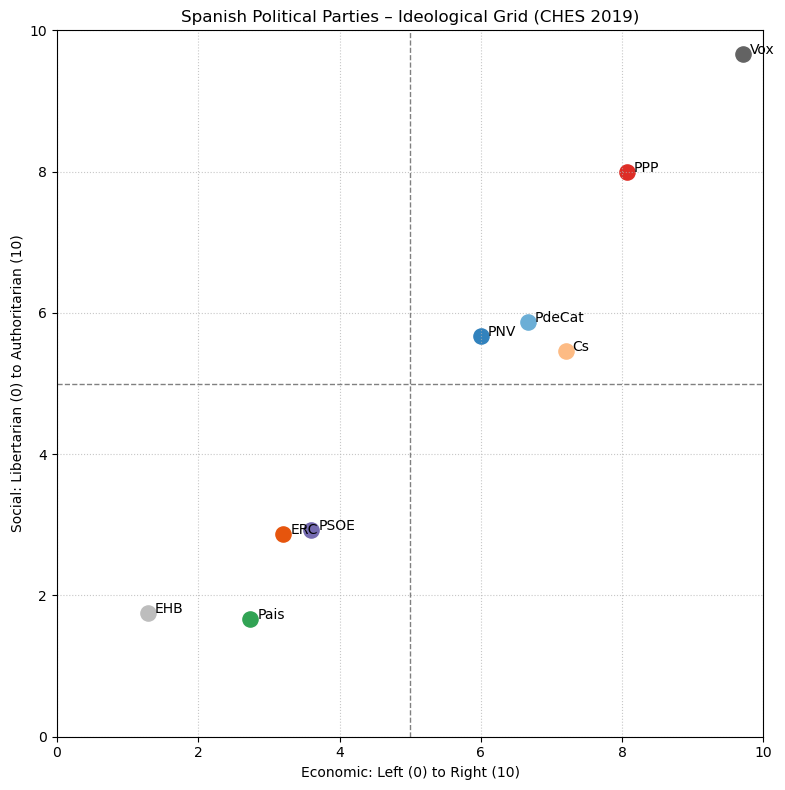

In [41]:
###############################################
# Plot using Chapel Hill Expert Survey, Extra #
###############################################

# -------------------------------------------
# 1. Load the CHES 2019 Dataset
# -------------------------------------------
ches_df = pd.read_csv("CHES2019V3.csv")  # Replace with your actual file path

# -------------------------------------------
# 2. Filter for Spanish Parties (country code = 5)
# -------------------------------------------
spanish_parties = ches_df[ches_df["country"] == 5]

# -------------------------------------------
# 3. Map Your Selected Parties to CHES Naming
# -------------------------------------------
party_mapping = {
    'Ciudadanos': 'Cs',
    'Más País': 'Pais',
    'EAJ-PNV': 'PNV',
    'PP': 'PPP',
    'PSOE': 'PSOE',
    'ERC': 'ERC',
    'VOX': 'Vox',
    'EH Bildu': 'EHB',
    'Junts': 'PdeCat'  # Historical alias for Junts
}

# This preserves the party order you want
party_order = list(party_mapping.keys())
ches_party_names = [party_mapping[p] for p in party_order]

# Filter only those Spanish parties in your list
selected_parties = spanish_parties[spanish_parties["party"].isin(ches_party_names)]

# -------------------------------------------
# 4. Extract Coordinates and Sort by Your Order
# -------------------------------------------
# Create a DataFrame with 'party', 'lrgen', 'galtan'
ideology_data = selected_parties[["party", "lrgen", "galtan"]]

# Reindex to preserve the custom order (by mapping reversed)
# Reindex to preserve the custom order (by mapping reversed)
party_index_map = {v: i for i, v in enumerate(ches_party_names)}
ideology_data = ideology_data.copy()  # prevent SettingWithCopyWarning
ideology_data.loc[:, "sort_order"] = ideology_data["party"].map(party_index_map)
ideology_data = ideology_data.sort_values("sort_order")

# -------------------------------------------
# 5. Define Colors (One per Party, in Order)
# -------------------------------------------
party_colors = [
    "#fdbb84",  # Ciudadanos – light orange
    "#31a354",  # Más País – green
    "#3182bd",  # EAJ-PNV – blue
    "#de2d26",  # PP – red
    "#756bb1",  # PSOE – purple
    "#e6550d",  # ERC – dark orange
    "#636363",  # VOX – gray
    "#bdbdbd",  # EH Bildu – light gray
    "#6baed6"   # Junts (PdeCat) – sky blue
]

# -------------------------------------------
# 6. Plot the Political Compass
# -------------------------------------------
plt.figure(figsize=(10, 8))

# Scatter plot each party with its assigned color
for i, (_, row) in enumerate(ideology_data.iterrows()):
    plt.scatter(row["lrgen"], row["galtan"], s=120, color=party_colors[i])
    plt.text(row["lrgen"] + 0.1, row["galtan"], row["party"], fontsize=10)

# Axis lines to show quadrants
plt.axhline(y=5, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=5, color='gray', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel("Economic: Left (0) to Right (10)" )# [lrgen]
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)") # [galtan]
plt.title("Spanish Political Parties – Ideological Grid (CHES 2019)")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')  # Force square aspect
plt.show()


Benchmark

In [44]:
##############################
# Benchmark data - explained #
##############################

# -------------------------------------------
# Load the Benchmark Dataset of Initiatives
# -------------------------------------------
# This benchmark dataset contains voting records on legislative initiatives in Spain from 2016 to 2025.
# Each row is one initiative; columns show votes from different parties and metadata.
initiatives_path = "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv"
initiatives_df = pd.read_csv(initiatives_path)

# -------------------------------------------
# 2. Explore the Dataset Structure
# -------------------------------------------
# Check the first few rows to see what the data looks like
print(initiatives_df.head())

# Print column names to understand what information is available
print("\nAvailable columns:")
print(initiatives_df.columns.tolist())

# -------------------------------------------
# 🗳️ 3. Count How Many Initiatives [a party] Voted On
# -------------------------------------------
# In this dataset, party votes are stored in columns named after parties.
# Vote values seem to be:
#   - 1 = Voted in favor
#   - 0 = Voted against
#   - NaN = Did not vote or was absent

# Count how many initiatives have a recorded vote (not NaN) from CUP
# ciudadanos_votes_count = df["..."].notna().sum()

# print(f"\n✅ [Party] participated in {cup_votes_count} initiatives (voted for, against, or abstained).")

           id                                              title  \
0  042/000002  Dictamen de la Comisión del Estatuto de los Di...   
1  042/000003  Dictamen de la Comisión del Estatuto de los Di...   
2  042/000010  Dictamen de la Comisión del Estatuto de los Di...   
3  042/000011  Dictamen de la Comisión del Estatuto de los Di...   
4  042/000012  Dictamen de la Comisión del Estatuto de los Di...   

                                          initiative  author  num_support  \
0  Dictamen de la Comisión del Estatuto de los Di...     NaN          309   
1  Dictamen de la Comisión del Estatuto de los Di...     NaN          550   
2  Dictamen de la Comisión del Estatuto de los Di...     NaN          342   
3  Dictamen de la Comisión del Estatuto de los Di...     NaN          301   
4  Dictamen de la Comisión del Estatuto de los Di...     NaN          305   

   num_against  num_abstained  passed                       documentcategory  \
0            2              6    True  Comisione

New dataset with all party votes and LLM votes

In [47]:
###################################################################################
# Putting the experiment results together with the benchmark dtaaset for analysis #
###################################################################################

# -------------------------------------------
# 1. Load Benchmark and LLM Results
# -------------------------------------------
benchmark_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

llm_all_df = pd.concat([
    pd.read_csv("Second_Experiments_Results/falcon3_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/gemma2_9b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/llama3_8b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/deepseek_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/mistral_7b_results_ideology_ES_prompt=1.csv"),
    pd.read_csv("Second_Experiments_Results/aguila7b_results_ideology_ES_prompt=1.csv")
], ignore_index=True)

# -------------------------------------------
# 2. Melt LLM Result Columns to Long Format
# -------------------------------------------
vote_columns = [
    'falcon3_7b_vote',
    'gemma2_9b_vote',
    'llama3_8b_vote',
    'deepseek_7b_vote',
    'mistral_7b_vote',
    'aguila7b_vote'
]

vote_melted_df = llm_all_df.melt(
    id_vars=["id", "initiative"],
    value_vars=vote_columns,
    var_name="model_vote_column",
    value_name="llm_vote"
)

vote_melted_df["model"] = vote_melted_df["model_vote_column"].str.replace("_vote", "", regex=False)

# -------------------------------------------
# 3. Pivot So Models Become Columns
# -------------------------------------------
llm_wide_df = vote_melted_df.pivot_table(
    index=["id", "initiative"],
    columns="model",
    values="llm_vote"
).reset_index()

# -------------------------------------------
# 4. Merge with Full Benchmark on id + initiative
# -------------------------------------------
merged_df = pd.merge(benchmark_df, llm_wide_df, on=["id", "initiative"], how="left")

# -------------------------------------------
# 5. Save Final Dataset with All Original Columns + Model Votes
# -------------------------------------------
#merged_df.to_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv", index=False)
print(" Saved: all_initiatives_full_with_llm_votes.csv")


 Saved: all_initiatives_full_with_llm_votes.csv


In [49]:
##########################################################
# CONFIGURATION FOR LLM POLITICAL BIAS ANALYSIS IN SPAIN #
##########################################################

# Seed for reproducibility
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)

# Experiment flags
DEBUG = False
exp_var = 1
remove_minor_parties = False  # You can toggle this for subsetting
results_folder = 'results'
results_latex_folder = 'results_latex'

# Spanish political party codes (used in dataset)
party_codes = [
    'Ciudadanos',
    'Más País',
    'EAJ-PNV',
    'PP',
    'PSOE',
    'CUP',
    'ERC',
    'VOX',
    'EH Bildu',
    'Junts'
]

# Full party names in Spanish (if needed for visualization or prompts)
party_names_ES = [
    'Ciudadanos',
    'Más País',
    'Euzko Alderdi Jeltzalea - Partido Nacionalista Vasco',
    'Partido Popular',
    'Partido Socialista Obrero Español',
    "Candidatura d'Unitat Popular",
    'Esquerra Republicana de Catalunya',
    'Vox',
    'Euskal Herria Bildu',
    'Junts per Catalunya'
]

# Subsets for testing or filtering
party_names_ES_ex_small = ["PSOE", "PP", "VOX"]
party_codes_ex_small = ["psoe", "pp", "vox"]

# Ideological tags (optional use)
direction_ES = ['izquierda', 'derecha', 'centro']
direction_codes = ['left', 'right', 'center']

# ========== MODEL DEFINITIONS ==========

# Full model names (used in processing)
llama3_name = 'Llama3-instruct'
llama70_name = 'Llama3-70B-instruct'
mistral_name = 'Mistral-instruct'
gemma2_name = 'Gemma2-instruct'
falcon3_name = 'Falcon3-instruct'
deepseek_name = 'DeepSeek-instruct'

# Short names for display
llama3_name_short = 'LLaMA 3 8B'
llama70_name_short = 'LLaMA 3 70B'
mistral_name_short = 'Mistral'
gemma2_name_short = 'Gemma 2'
falcon3_name_short = 'Falcon 3'
deepseek_name_short = 'DeepSeek'

# Final model list
model_names = [
    mistral_name,
    falcon3_name,
    gemma2_name,
    deepseek_name,
    llama3_name,
    # llama70_name  # Add this if you have 70B results later
]

model_names_short = {
    mistral_name: mistral_name_short,
    falcon3_name: falcon3_name_short,
    gemma2_name: gemma2_name_short,
    deepseek_name: deepseek_name_short,
    llama3_name: llama3_name_short,
    # llama70_name: llama70_name_short,
}

model_names_short_list = [model_names_short[m] for m in model_names]

# Color scheme (matches your violin plot)
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4']

# Results file pattern (same suffix for each model)
results_suffix = '_results_ideology_ES_prompt=1.csv'

# Folder to output LaTeX tables (if later needed)
results_latex_file = f'{results_latex_folder}/process_results_{exp_var}.tex'



In [51]:
# Make sure the folder exists before writing to the file
os.makedirs(results_latex_folder, exist_ok=True)

# make sure we start with an empty file
open(results_latex_file, 'w').close()

# move to utils
def write_to_latex(latex_text):
    # Write all macros to a file (e.g., tables_macros.tex).
    print("write to latex")
    print(latex_text)
    with open(results_latex_file, "a") as f_out:
        f_out.write(latex_text+"\n\n")


def write_latex_variable(var_name, var_value):
    latex_text = f"\\newcommand{{\\{var_name}}}{{{var_value}}}\\ignorespaces\n"
    write_to_latex(latex_text)


Prompt search

In [54]:
#########################################################################################
# Calculating the average confidence for each vote type (for/against/abstain) per model #
#########################################################################################

# Folder where model result CSVs are stored
results_folder = "results"

# Load your data
file_paths = glob.glob("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results/*_results_ideology_ES_prompt=1.csv") 

# List to store cleaned DataFrames
dfs = []

# Loop through files, standardize column names, and tag with model name
for file in file_paths:
    model_name = os.path.basename(file).split("_results")[0]  # e.g., llama3_8b
    df = pd.read_csv(file)

    # Rename model-specific probability columns to generic ones
    df.rename(columns={
        f"{model_name}_for_prob": "for_prob",
        f"{model_name}_against_prob": "against_prob",
        f"{model_name}_abstain_prob": "abstain_prob",
        f"{model_name}_vote": "vote"
    }, inplace=True)

    df["Model"] = model_name
    dfs.append(df)

# Combine all model data
df_all = pd.concat(dfs, ignore_index=True)

# Group by model and compute average scores
df_summary = df_all.groupby("Model")[["for_prob", "against_prob", "abstain_prob"]].mean().reset_index()

# Convert to percentages
df_summary[["for_prob", "against_prob", "abstain_prob"]] *= 100

# Rename for readability
df_summary.rename(columns={
    "for_prob": "For (%)",
    "against_prob": "Against (%)",
    "abstain_prob": "Abstain (%)"
}, inplace=True)

# Set index for LaTeX export
df_summary.set_index("Model", inplace=True)

# Export to LaTeX string
latex_code = df_summary.to_latex(float_format="%.2f")
print(latex_code)

# (Optional) save to file if needed
save_latex = False
if save_latex:
    latex_output_path = "results_latex/model_confidence_summary.tex"
    os.makedirs(os.path.dirname(latex_output_path), exist_ok=True)
    with open(latex_output_path, "w") as f:
        f.write(latex_code)

\begin{tabular}{lrrr}
\toprule
 & For (%) & Against (%) & Abstain (%) \\
Model &  &  &  \\
\midrule
aguila7b & 8.74 & 11.47 & 79.79 \\
deepseek_7b & 6.59 & 31.66 & 61.75 \\
falcon3_7b & 12.11 & 33.67 & 54.22 \\
gemma2_9b & 2.08 & 0.92 & 96.99 \\
llama3_8b & 93.86 & 5.33 & 0.82 \\
mistral_7b & 5.96 & 15.88 & 78.16 \\
\bottomrule
\end{tabular}



Samples of initiatives

In [57]:
##########################################
# Showing a random sample of initiatives #
##########################################

# Load a single model file (any will do for the sample initiatives)
sample_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

print("FINAL DATASET AUDIT\n" + "-"*40)
print("Total rows (model × initiative × party):", len(df))

# Check column types
print("\nColumn Overview:")
print(df.dtypes)

# ========== LaTeX Table Renderer ==========

def render_latex_table(df, table_name):
    col1 = df.columns[1]
    lines = [
        r"\begin{table}[H]",
        r"\centering",
        r"\begin{center}",
        r"\begin{tabularx}{\linewidth}{| l | X |}",
        r"  \hline",
        rf"  \thead{{\textbf{{Id}}}} & \thead{{\textbf{{{col1}}}}} \\",
        r"  \hline",
    ]
    for _, row in df.iterrows():
        lines.append(f"{row['id']} & {row[col1]} \\\\")
        lines.append(r"\hline")
    lines += [
        r"\end{tabularx}",
        r"\end{center}",
        rf"\caption{{Ejemplos de iniciativas - {col1}}}",
        rf"\label{{tab:{col1.replace(' ', '').replace('(', '').replace(')', '')}}}",
        r"\end{table}"
    ]
    return "\n".join(lines)

# ========== Generate LaTeX and Macro Definition ==========

latex = render_latex_table(sample_df[:10], "Iniciativa (ES)")
latex = latex.replace('%', r'\%')  # escape % for LaTeX

macro_definition = (
    r"\newcommand{\SamplesES}{" + "\n"
    r"\ignorespaces" + "\n"
    f"{latex}" + "\n"
    r"}" + "\n"
)

# Write to LaTeX file (if you used the `write_to_latex()` function earlier)
write_to_latex(macro_definition)


FINAL DATASET AUDIT
----------------------------------------
Total rows (model × initiative × party): 2480

Column Overview:
Unnamed: 0        int64
id               object
initiative       object
vote              int64
for_prob        float64
against_prob    float64
abstain_prob    float64
Model            object
dtype: object
write to latex
\newcommand{\SamplesES}{
\ignorespaces
\begin{table}[H]
\centering
\begin{center}
\begin{tabularx}{\linewidth}{| l | X |}
  \hline
  \thead{\textbf{Id}} & \thead{\textbf{title}} \\
  \hline
042/000002 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000003 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000010 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000011 & Dictamen de la Comisión del Estatuto de los Diputados sobre incompatibilidades. \\
\hline
042/000012 & Dictamen de la Comisión del Estatuto de

Word counts

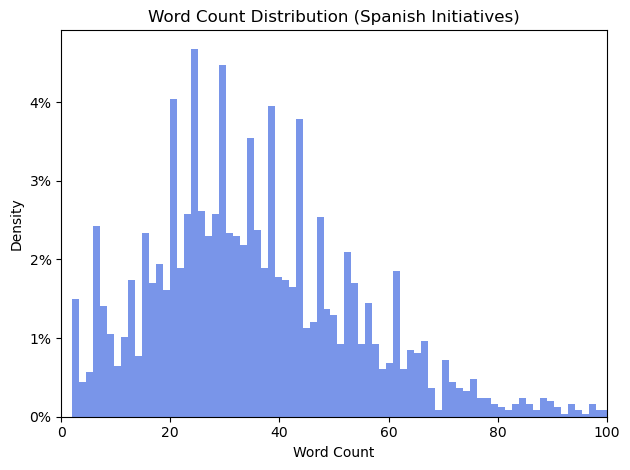

Min: 2
Max: 130
Mean: 35.983467741935485
Initiatives with < 3 words:
 ['Título I' 'Título II' 'Título III' 'Título V' 'Título VI' 'Título VII'
 'Título VIII' 'Anexos  null']


In [60]:
#################################################
# Counting the words of the initiatives - stats #
#################################################

# Load your cleaned Spanish dataset
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# Compute word counts
df['word_count'] = df['initiative'].str.split().str.len()

# Drop NaNs if any
df = df[df['word_count'].notna()]
counts = df['word_count'].astype(int)

# Plot histogram
fig, ax = plt.subplots()

weights = np.ones_like(counts) / len(counts)

ax.hist(counts, bins=100, weights=weights, color="royalblue", alpha=0.7)

ax.set_xlabel("Word Count")
ax.set_ylabel("Density")
ax.set_title("Word Count Distribution (Spanish Initiatives)")

ax.yaxis.set_major_locator(MultipleLocator(0.01))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
ax.set_xlim(0, 100)
plt.tight_layout()

# Save figure
plt.savefig("results_latex/word_counts_spanish.png")
plt.show()

# Print stats
print("Min:", counts.min())
print("Max:", counts.max())
print("Mean:", counts.mean())
print("Initiatives with < 3 words:\n", df[df['word_count'] < 3]['initiative'].unique())


✅ 1. Data Integrity & Filtering
The presence of ultra-short entries like 'Título I' indicates you may want to filter out structural fragments that were incorrectly included. These are not legitimate legislative texts, and LLMs would likely abstain or hallucinate responses to them.

📌 You can safely filter:

python
Kopiëren
Bewerken
df = df[df['word_count'] >= 5]
...to exclude structural artifacts and non-substantive motions.

✅ 2. Justification of Preprocessing
In your methodology section, you can now clearly state:

"We observed that a small subset of initiatives consisted of extremely short entries (e.g., 'Título II'), likely representing document section headers rather than substantive proposals. These were excluded from further analysis using a length threshold of 5 words, improving the semantic relevance of model inputs."

This demonstrates rigor in cleaning, and shows your dataset is truly composed of real legislative text.

✅ 3. Consistency Across Initiatives
The histogram also shows a healthy, relatively compact range of word lengths, which is good. If the distribution were extremely wide (e.g., 10 to 1,000+ words), you'd need to consider normalizing inputs, truncating, or splitting texts.

Since your max is 130, you're likely within safe bounds for all LLMs, even without truncation.

Results Party Motions and Votes

Function - Motions

In [65]:
import pandas as pd

def create_motion_proposal_summary2(df_ideology, party_codes):
    
    return pd.DataFrame(motions_summary_data).set_index("Party")

Function - Votes

In [68]:
###########################################################################################################################
# Generating a summary table of vote counts and percentages (for, against, other) for each party or model in the dataset. #
###########################################################################################################################

def create_vote_summary_df(df_ideology, party_cols, header="Party"):
    summary_data = []
    print("Total motions analyzed:", len(df_ideology))

    for col in party_cols:
        counts = df_ideology[col].value_counts().reindex([1.0, -1.0, 0.0], fill_value=0)
        proportions = df_ideology[col].value_counts(normalize=True).reindex([1.0, -1.0, 0.0], fill_value=0)

        summary_data.append({
            header: col,
            "Count of For": int(counts[1.0]),
            "Count of Against": int(counts[-1.0]),
            "Count of Other": int(counts[0.0]),
            "For (%)": f"{proportions[1.0]*100:.1f}",
            "Against (%)": f"{proportions[-1.0]*100:.1f}",
            "Other (%)": f"{proportions[0.0]*100:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df.set_index(header)

party_cols = ['PSOE', 'PP', 'VOX', 'Ciudadanos', 'CUP', 'ERC', 'Junts', 'EH Bildu', 'PNV', 'Más País']  # or your desired columns
summary_df = create_vote_summary_df(df_ideology, party_cols, header="Party")
print(summary_df)


NameError: name 'df_ideology' is not defined

Initiatives

In [71]:
##################################################################################################
# Generating a summary DataFrame showing the proportion of motions proposed by each party across #
# the full period and three custom time periods (2016–2019, 2019–2023, 2023–2025).               #
##################################################################################################

def get_df_initiative_summary_all(df_initiatives, party_codes):
    # -------------------------------------------
    # STEP 1: Extract year from date column
    # -------------------------------------------
    df_initiatives = df_initiatives.copy()
    df_initiatives["year"] = pd.to_datetime(df_initiatives["date"], dayfirst=True).dt.year

    # -------------------------------------------
    # STEP 2: Full-period summary
    # -------------------------------------------
    df_summary_all = create_motion_proposal_summary2(df_initiatives, party_codes)

    # -------------------------------------------
    # STEP 3: Define custom periods
    # -------------------------------------------
    periods = {
        "2016–2019": list(range(2016, 2020)),
        "2019–2023": list(range(2019, 2024)),
        "2023–2025": list(range(2023, 2026)),
    }

    # -------------------------------------------
    # STEP 4: Filter and compute summaries per period
    # -------------------------------------------
    summaries = {}
    for label, years in periods.items():
        mask = df_initiatives["year"].isin(years)
        summaries[label] = create_motion_proposal_summary2(df_initiatives[mask].copy(), party_codes)

    # -------------------------------------------
    # STEP 5: Rename columns
    # -------------------------------------------
    df_summary_all.rename(columns={"Motions (%)": "All"}, inplace=True)
    for label, df in summaries.items():
        df.rename(columns={"Motions (%)": label}, inplace=True)

    # -------------------------------------------
    # STEP 6: Merge all into one DataFrame
    # -------------------------------------------
    df_combined = pd.concat(
        [df_summary_all] + [summaries[label][label] for label in periods],
        axis=1,
        join="inner"
    )

    return df_combined

Initiative Stats

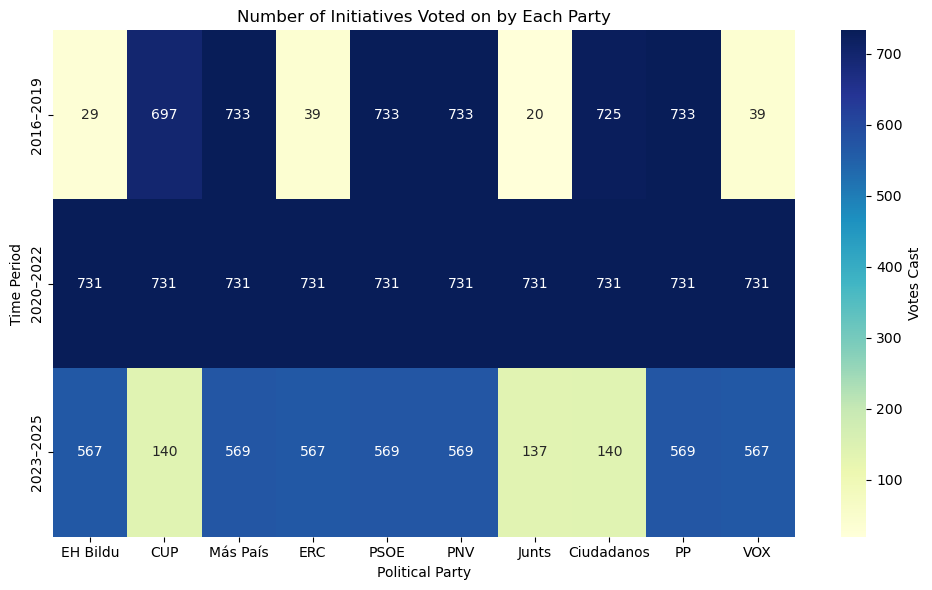

In [131]:
##################################################################################################
# Initiative voting data, extracts the year from dates, counts how many initiatives each Spanish #
# party voted on during defined time periods, and visualizes the results in a heatmap.           #
##################################################################################################

# --------------------------------------------------
# STEP 1: Load your dataset
# --------------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# --------------------------------------------------
# STEP 2: Convert date to datetime and extract year
# --------------------------------------------------
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["year"] = df["date"].dt.year

# --------------------------------------------------
# STEP 3: Define party columns and time periods
# --------------------------------------------------
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']


# Define custom periods
periods = {
    "2016–2019": list(range(2016, 2019)),
    "2020–2022": list(range(2020, 2022)),
    "2023–2025": list(range(2023, 2026))
}

# --------------------------------------------------
# STEP 4: Count votes (i.e. non-null values) per party in each period
# --------------------------------------------------
summary = pd.DataFrame(index=party_cols)

for label, years in periods.items():
    mask = df["year"].isin(years)
    df_period = df.loc[mask, party_cols]
    
    # Count how many votes (non-null values) each party cast in this period
    counts = df_period.notna().sum()
    summary[label] = counts

# --------------------------------------------------
# STEP 5: Plot the heatmap
# --------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(summary.T, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Votes Cast"})
plt.title("Number of Initiatives Voted on by Each Party")
plt.xlabel("Political Party")
plt.ylabel("Time Period")
plt.tight_layout()
plt.show()


Parties votes

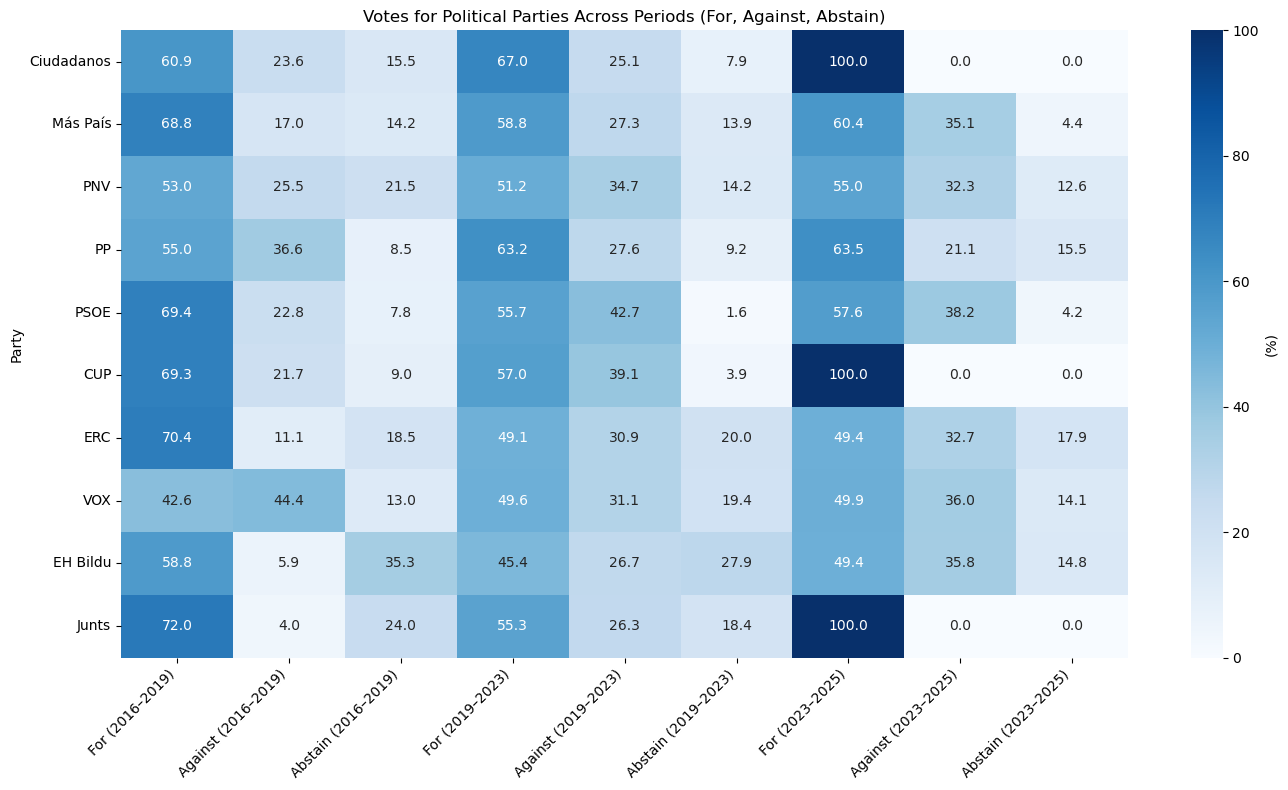

In [139]:
###############################################################################################
# Initiative voting data, assigns each vote to a parliamentary period,                        #
# computes the percentage of "For", "Against", and "Abstain" votes per party for each period  #
###############################################################################################

# -----------------------------------------------
# 1. Load your initiative vote data
# -----------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")

# -----------------------------------------------
# 2. Convert date and assign period
# -----------------------------------------------
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# Define your parliamentary periods
periods = {
    "2016–2019": (pd.Timestamp("2016-01-01"), pd.Timestamp("2019-12-31")),
    "2019–2023": (pd.Timestamp("2020-01-01"), pd.Timestamp("2023-06-30")),
    "2023–2025": (pd.Timestamp("2023-07-01"), pd.Timestamp("2025-12-31")),
}

# Assign a period to each row
def assign_period(date):
    for label, (start, end) in periods.items():
        if start <= date <= end:
            return label
    return None

df["period"] = df["date"].apply(assign_period)

# -----------------------------------------------
# 3. Prepare vote summary function (with Abstain)
# -----------------------------------------------
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']


def create_vote_summary(df_slice):
    summary = {}
    for party in party_columns:
        total = df_slice[party].notna().sum()
        if total == 0:
            summary[party] = {"For": 0, "Against": 0, "Abstain": 0}
            continue
        votes_for = (df_slice[party] == 1).sum() / total * 100
        votes_against = (df_slice[party] == -1).sum() / total * 100
        votes_abstain = (df_slice[party] == 0).sum() / total * 100
        summary[party] = {
            "For": votes_for,
            "Against": votes_against,
            "Abstain": votes_abstain
        }
    return pd.DataFrame(summary).T

# -----------------------------------------------
# 4. Calculate summaries for each period
# -----------------------------------------------
df_vote_summary_all = pd.DataFrame()

for label in periods:
    summary = create_vote_summary(df[df["period"] == label])
    summary.columns = [f"{col} ({label})" for col in summary.columns]
    df_vote_summary_all = pd.concat([df_vote_summary_all, summary], axis=1)

# -----------------------------------------------
# 5. Plot heatmap
# -----------------------------------------------
plt.figure(figsize=(14, 8))
sns.heatmap(df_vote_summary_all, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"label": "(%)"})
plt.title("Votes for Political Parties Across Periods (For, Against, Abstain)")
plt.ylabel("Party")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Agreement amongst parties

Mean off-diagonal similarity: 53.5%


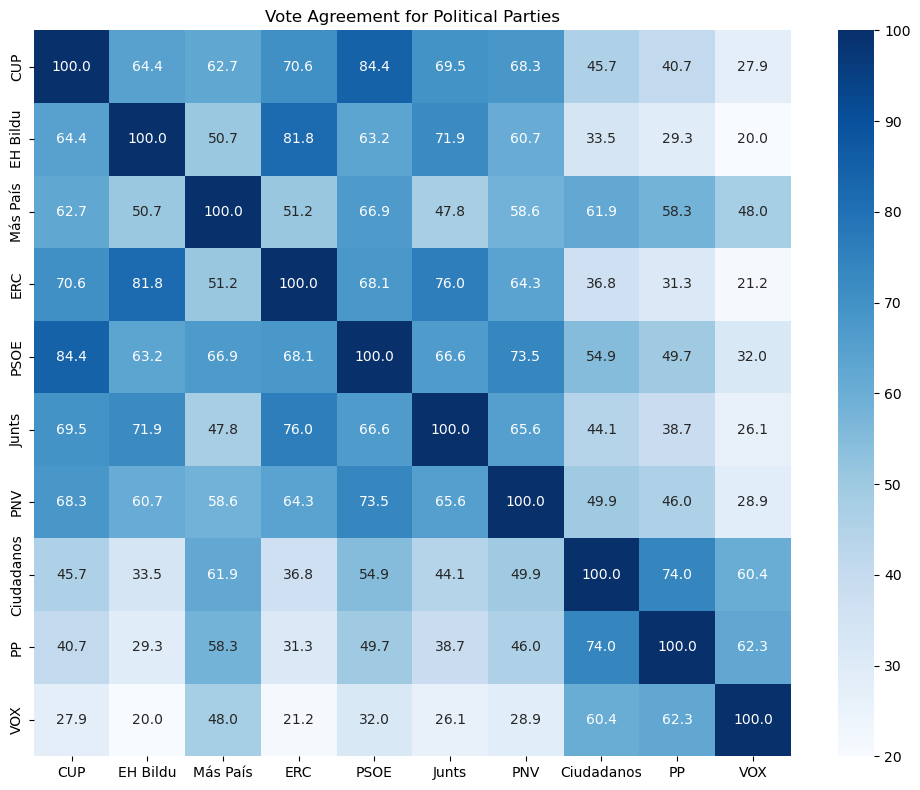

In [145]:
##################################################################################################
# Calculates how often each pair of 10 political parties voted the same on shared initiatives,   #
# computing the average inter-party agreement, and visualizes the agreement matrix as a heatmap. #
##################################################################################################

# -----------------------------------------------
# 1. Load data
# -----------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/All_initiatives_2016-2025.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# -----------------------------------------------
# 2. Define the party codes (your 10 parties)
# -----------------------------------------------
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']


party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
# -----------------------------------------------
# 3. Create Agreement Matrix
# -----------------------------------------------
df_agreement_parties = pd.DataFrame(index=party_codes, columns=party_codes, dtype=float)

for p1 in party_codes:
    for p2 in party_codes:
        mask = df[p1].notna() & df[p2].notna()
        total_shared = mask.sum()
        
        if total_shared == 0:
            df_agreement_parties.loc[p1, p2] = np.nan
            continue

        if p1 == p2:
            df_agreement_parties.loc[p1, p2] = 100.0
        else:
            same_votes = (df.loc[mask, p1] == df.loc[mask, p2]).sum()
            df_agreement_parties.loc[p1, p2] = round(100 * same_votes / total_shared, 1)
# -----------------------------------------------
# 4. Compute Mean Off-Diagonal Similarity
# -----------------------------------------------
mask = ~np.eye(len(party_codes), dtype=bool)

mean_similarity = (
    df_agreement_parties
    .where(mask)
    .stack()
    .mean()
)

print(f"Mean off-diagonal similarity: {mean_similarity:.1f}%")

# If using LaTeX output helper, otherwise skip this line
# write_latex_variable("partyvoteagreement", f"{mean_similarity:.1f}%")

# -----------------------------------------------
# 5. Heatmap of Agreement
# -----------------------------------------------
def heat_plot(df, title, xlabels, ylabels, filename):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="Blues", xticklabels=xlabels, yticklabels=ylabels)
    plt.title(title)
    plt.tight_layout()
    plt.show()

heat_plot(
    df_agreement_parties[party_codes_left_right].T,
    "Vote Agreement for Political Parties",
    party_codes_left_right,
    party_codes_left_right,
    "vote_agreement_parties"
)


LLM Votes

In [148]:
################################################################################################
# Calculating and summarizes the percentage distribution of vote types (for, against, abstain) #
# for each LLM by reading their respective voting result files.                                #
################################################################################################

# -----------------------------------------------
# 1. Input files and expected columns
# -----------------------------------------------
files = [
    "Second_Experiments_Results/deepseek_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/falcon3_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/gemma2_9b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/llama3_8b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/mistral_7b_results_ideology_ES_prompt=1.csv",
    "Second_Experiments_Results/aguila7b_results_ideology_ES_prompt=1.csv"
]

cols = [
    'deepseek_7b_vote',
    'falcon3_7b_vote',
    'gemma2_9b_vote',
    'llama3_8b_vote',
    'mistral_7b_vote',
    'aguila7b_vote'
]

# -----------------------------------------------
# 2. Count vote % for each model
# -----------------------------------------------
pct_dict = {}

for path, col in zip(files, cols):
    df = pd.read_csv(path)

    # Ensure votes are numeric (e.g. 1, 0, -1)
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Count % of each vote type
    pct = (
        df[col]
        .value_counts(normalize=True)
        .mul(100)
        .round(1)
    )

    model = col.replace('_vote', '')
    pct_dict[model] = pct

# -----------------------------------------------
# 3. Create summary table
# -----------------------------------------------
pct_df = pd.DataFrame(pct_dict).fillna(0).sort_index()

print(pct_df)

    deepseek_7b  falcon3_7b  gemma2_9b  llama3_8b  mistral_7b  aguila7b
-1         16.2        25.7        0.0        0.1         0.0      24.6
 0         13.8        63.1       97.7        6.4         0.6       3.9
 1         70.0        11.2        2.3       93.5        99.4      71.5


Stylized Facts

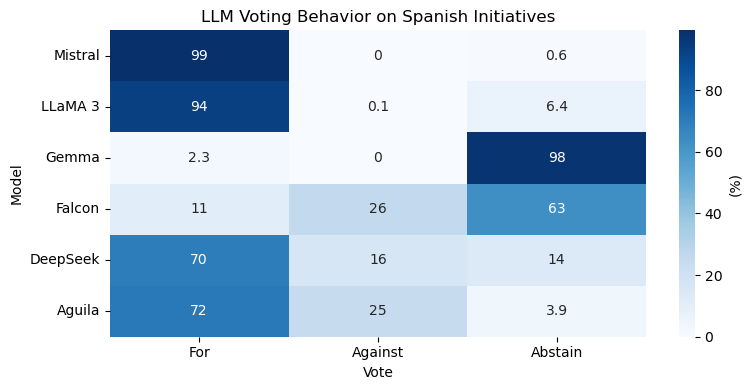

In [151]:
############################################################################################
# Spanish LLM voting data, calculates the percentage of vote types (For, Against, Abstain) #
# per model, and visualizes the results in a heatmap.                                      #
############################################################################################

# ---------------------------------------------
# 1. Load Spanish LLM Vote Data
# ---------------------------------------------
df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

model_names = ['mistral_7b', 'llama3_8b', 'gemma2_9b', 'falcon3_7b', 'deepseek_7b', 'aguila7b']
model_names_short = ['Mistral', 'LLaMA 3', 'Gemma', 'Falcon', 'DeepSeek', 'Aguila']
model_rename_dict = dict(zip(model_names, model_names_short))

# ---------------------------------------------
# 2. Create Vote Summary (% For / Against / Abstain)
# ---------------------------------------------
def create_vote_summary_df(df, vote_cols, label):
    summary = []
    for col in vote_cols:
        counts = df[col].value_counts(normalize=True).round(3) * 100
        for_ = counts.get(1, 0)
        against = counts.get(-1, 0)
        abstain = counts.get(0, 0)
        summary.append([col, for_, against, abstain])
    summary_df = pd.DataFrame(summary, columns=[label, "For", "Against", "Abstain"])
    return summary_df

summary_df_models = create_vote_summary_df(df, model_names, "LLMs")

# Rename to short names
summary_df_models["LLMs"] = summary_df_models["LLMs"].map(model_rename_dict)

# Set LLMs as index
summary_df_models.set_index("LLMs", inplace=True)

# ---------------------------------------------
# 3. Plot the Heatmap of Vote Tendencies
# ---------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.heatmap(summary_df_models[["For", "Against", "Abstain"]],
            annot=True, cmap="Blues", cbar_kws={"label": "(%)"})
plt.title("LLM Voting Behavior on Spanish Initiatives")
plt.xlabel("Vote")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


Ideology

PCA POLITICAL LANDSCAPE

Fit on parties, transform on models¶

2480
                  PCA1       PCA2
CUP          -3.448340 -24.143632
EH Bildu     -9.763885 -19.119805
Más País      5.863425  -5.192742
ERC          -9.445430 -20.807285
PSOE         -2.654827 -27.506993
Junts        -7.488325 -11.412146
PNV          -4.128574 -23.034378
Ciudadanos    5.850731  17.064700
PP            5.689555  25.046190
VOX          -4.665304  29.886296
mistral_7b   36.121692   2.332185
llama3_8b    33.500404   2.382912
gemma2_9b   -11.254425   6.688857
falcon3_7b  -22.105690   7.852474
deepseek_7b  17.463428   7.138252
aguila7b     14.363822   4.561470
Yes          36.344909   2.550430
Ran         -19.278740  13.841387
No          -60.964426  11.871831
['#fdbb84', '#31a354', '#3182bd', '#de2d26', '#756bb1', '#e6550d', '#636363', '#bdbdbd', '#6baed6', '#9ecae1']
['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']
Index(['PCA1', 'PCA2'], dtype='object')


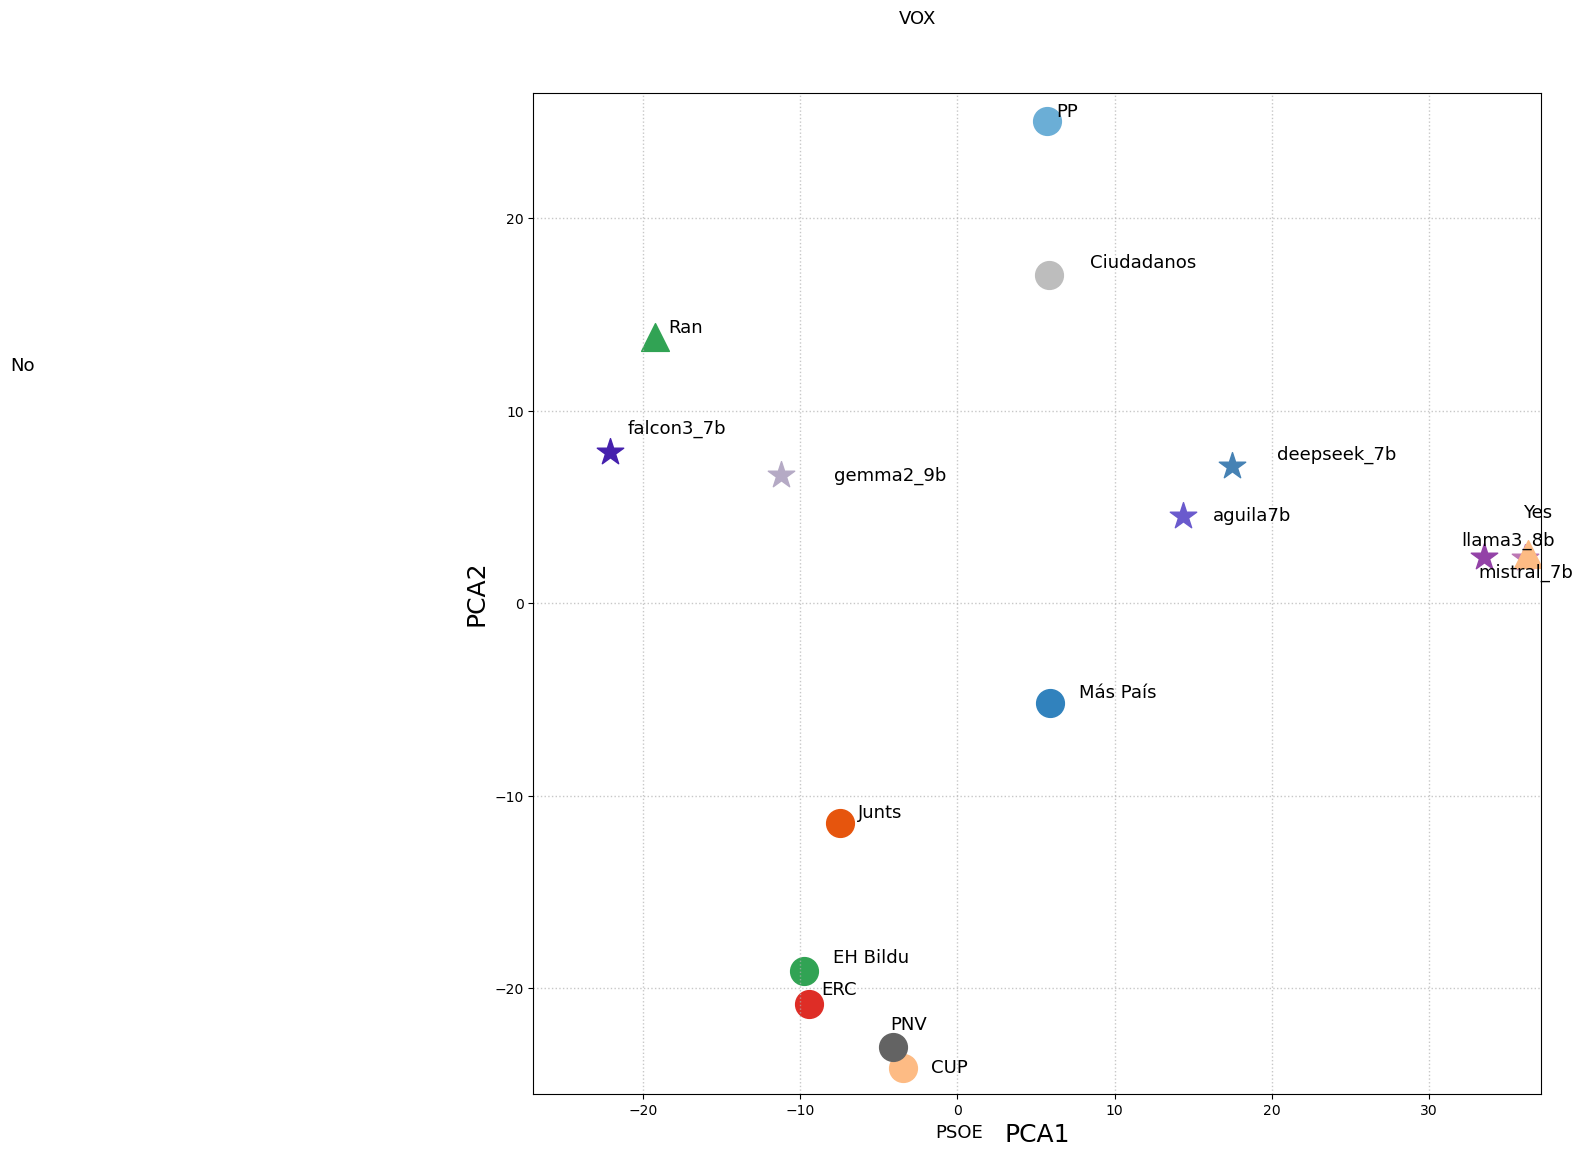

In [153]:
#######################################################################################
# Spanish party and LLM voting data, performs PCA to project them into a 2D political #
# landscape,and visualizes the ideological positions of parties and models.           #
#######################################################################################

# Load data
df_ideology = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# Reference columns (simulated voters)
df_ideology['Yes'] = 1
df_ideology['No'] = -1
df_ideology['Ran'] = np.random.choice([-1, 1], size=len(df_ideology))
men_cols = ['Yes', 'Ran', 'No']

# PCA configuration
fit_pca_parties = True
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['mistral_7b', 'llama3_8b', 'gemma2_9b', 'falcon3_7b', 'deepseek_7b', 'aguila7b']

# Define colors
colors_parties = [
    "#fdbb84", "#31a354", "#3182bd", "#de2d26", "#756bb1",
    "#e6550d", "#636363", "#bdbdbd", "#6baed6", "#9ecae1"
]
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']

# Execute PCA and plot
if fit_pca_parties:
    exp = "ES"
    exp_var = "v1"

    # Make sure no NaNs are present
    cols_used = party_codes + model_names_short_list + men_cols
    df_ideology[cols_used] = df_ideology[cols_used].fillna(0)

    # Plot using modular function
    pca_df, pca_model = plot_landscape2(
        df=df_ideology,
        title="Political Compass: Spanish Parties + LLMs",
        models=model_names_short_list + men_cols,
        exp=exp,
        party_codes=party_codes,
        colors_models=colors_models,
        colors_parties=colors_parties,
        exp_var=exp_var,
        signs=[1, 1]
    )


Centered

2480
                 PCA1       PCA2
CUP         19.094942  -5.238034
EH Bildu    17.776533  15.322825
Más País    -4.904237 -18.524463
ERC         19.105112  14.411293
PSOE        18.589019 -18.606670
Junts        9.784981  16.870964
PNV         15.537589 -10.351076
Ciudadanos -26.536801   0.265265
PP         -35.262243  -2.046581
VOX        -33.184896   7.896477
2480
                 PCA1       PCA2
mistral_7b  -6.879588  10.762783
llama3_8b   -7.142550   9.694483
gemma2_9b   -6.636644  10.647001
falcon3_7b  -5.644417  13.676353
deepseek_7b -7.521739  10.700759
aguila7b    -4.469151  10.231212
Yes         -7.100342  10.856556
Ran         -7.158417  10.365808
No          -7.100342  10.856556
['#fdbb84', '#31a354', '#3182bd', '#de2d26', '#756bb1', '#e6550d', '#636363', '#bdbdbd', '#6baed6', '#9ecae1']
['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD', '#bfbfbf', '#7f7f7f', '#3f3f3f']
Index(['PCA1', 'PCA2'], dtype='object')


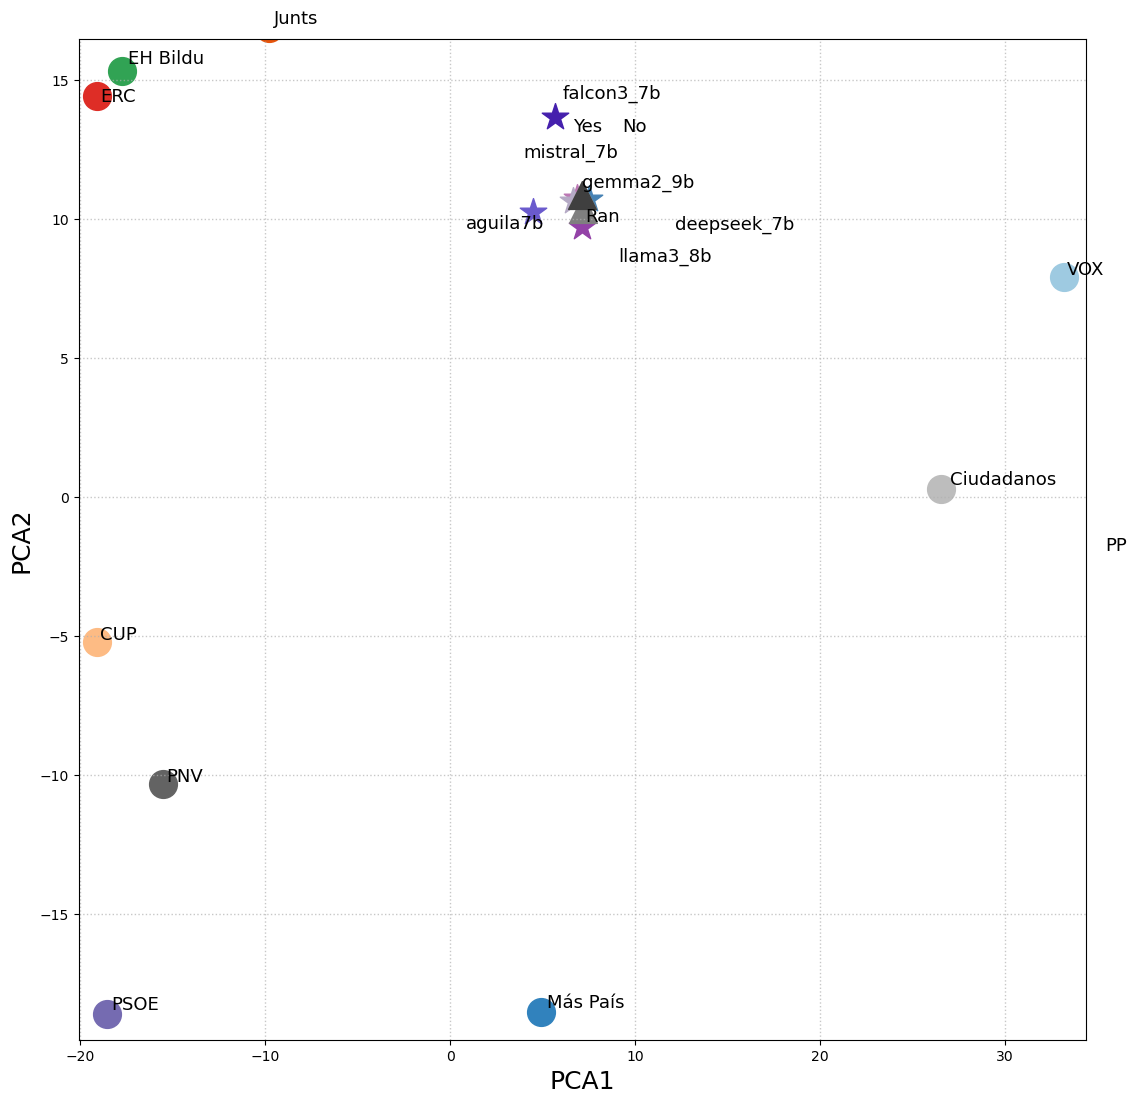

['#fdbb84', '#31a354', '#3182bd', '#de2d26', '#756bb1', '#e6550d', '#636363', '#bdbdbd', '#6baed6', '#9ecae1']
['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD', '#bfbfbf', '#7f7f7f']
Index(['PCA1', 'PCA2'], dtype='object')


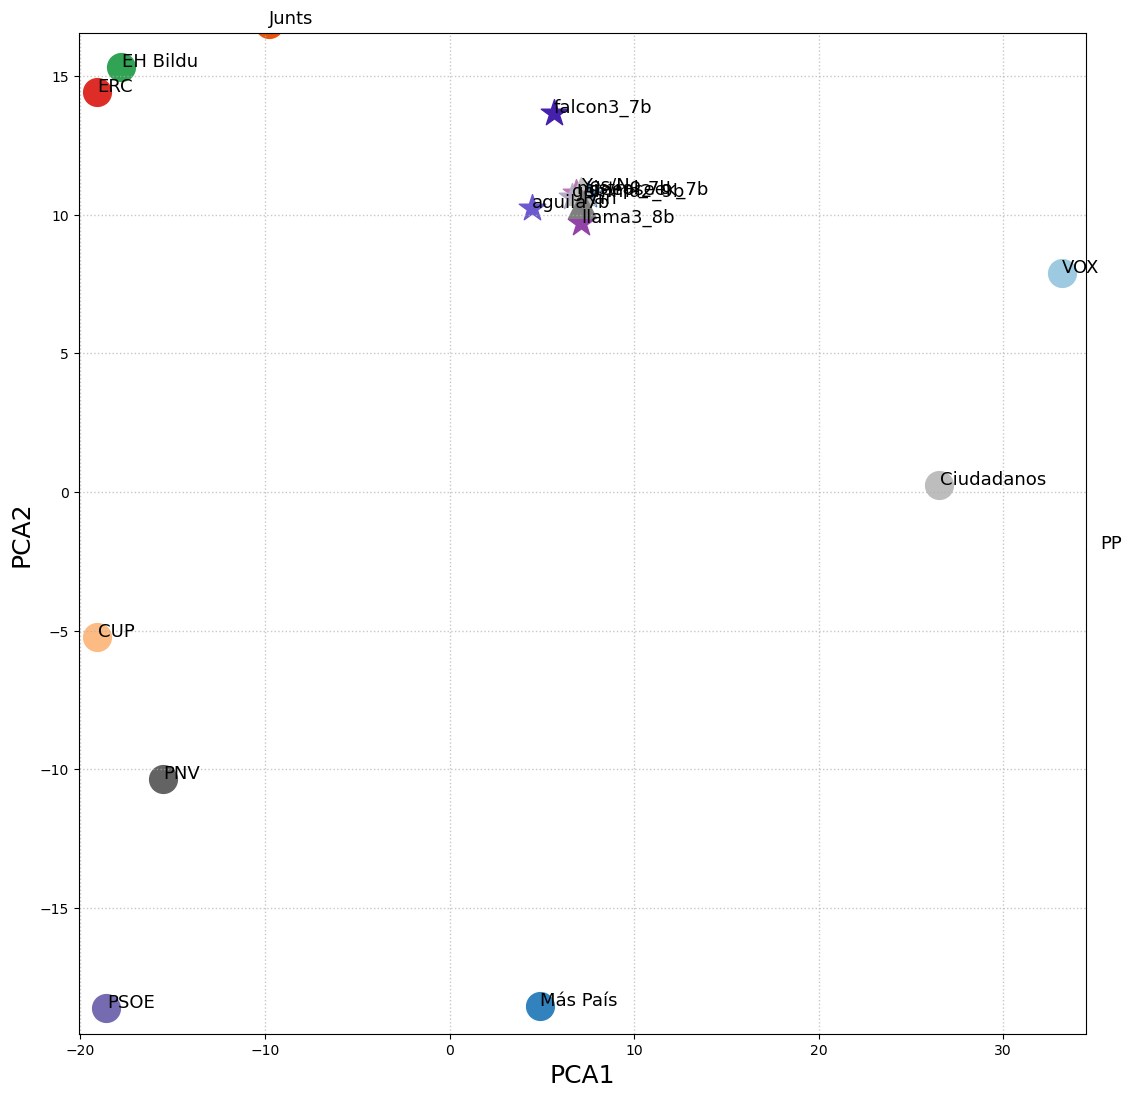

In [155]:
###############################################################################################
# Centering Spanish party and LLM voting data, performs PCA to project ideological positions, #
# and generates both full and zoomed-in political landscape plots including reference voters. #
###############################################################################################

# Load your main dataset
df_ideology = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# ----------------------------------------
# Step 1: Define Constants
# ----------------------------------------
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['mistral_7b', 'llama3_8b', 'gemma2_9b', 'falcon3_7b', 'deepseek_7b', 'aguila7b']
men_cols = ['Yes', 'Ran', 'No']
exp_var = "ES"
fit_pca_parties = True
undersample = False

# ----------------------------------------
# Step 2: Create reference voters
# ----------------------------------------
df_ideology['Yes'] = 1
df_ideology['No'] = -1
df_ideology['Ran'] = np.random.choice([-1, 1], size=len(df_ideology))

# ----------------------------------------
# Step 3: Define color schemes
# ----------------------------------------
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']
colors_men = ['#bfbfbf', '#7f7f7f', '#3f3f3f']  # Yes, Ran, No
colors_parties = [
    "#fdbb84", "#31a354", "#3182bd", "#de2d26", "#756bb1",
    "#e6550d", "#636363", "#bdbdbd", "#6baed6", "#9ecae1"
]

# ----------------------------------------
# Step 4: Mean-center the data
# ----------------------------------------
all_cols = party_codes + model_names_short_list + men_cols
df_centered = df_ideology[all_cols].copy()
df_centered = df_centered.sub(df_centered.mean(axis=0), axis=1)

# ----------------------------------------
# Step 5: Perform PCA and plot
# ----------------------------------------
if fit_pca_parties:
    signs = [-1, 1]
    zoom_lims = [[-6, 6], [-11, 1]]
    if undersample:
        signs = [1, 1]
        zoom_lims = [[-6, 6], [-10, 2]]

    pca_parties_df_cent, pca_model_cent = do_PCA(df_centered, [], party_codes)
    pca_models_df_cent, _ = do_PCA(df_centered, model_names_short_list + men_cols, [], pca_model=pca_model_cent)
    pca_df_cent = pd.concat([pca_parties_df_cent, pca_models_df_cent], ignore_index=False)

    make_landscape_plot(
        pca_df_cent,
        title='political_compass_parties_models_centered',
        models=model_names_short_list + men_cols,
        exp="ES",
        party_codes=party_codes,
        colors_models=colors_models + colors_men,
        colors_parties=colors_parties,
        exp_var=exp_var,
        signs=signs
    )

    # Zoomed version
    pca_df_cent = pca_df_cent.rename(index={'Yes': 'Yes/No'}).drop(index='No')
    make_landscape_plot(
        pca_df_cent,
        title='political_compass_models_zoomed_centered',
        models=model_names_short_list + ['Yes/No', 'Ran'],
        exp="ES",
        party_codes=party_codes,
        colors_models=colors_models + colors_men[:2],
        colors_parties=colors_parties,
        exp_var=exp_var,
        signs=signs,
        xlim=zoom_lims[0],
        ylim=zoom_lims[1]
    )

Certainty

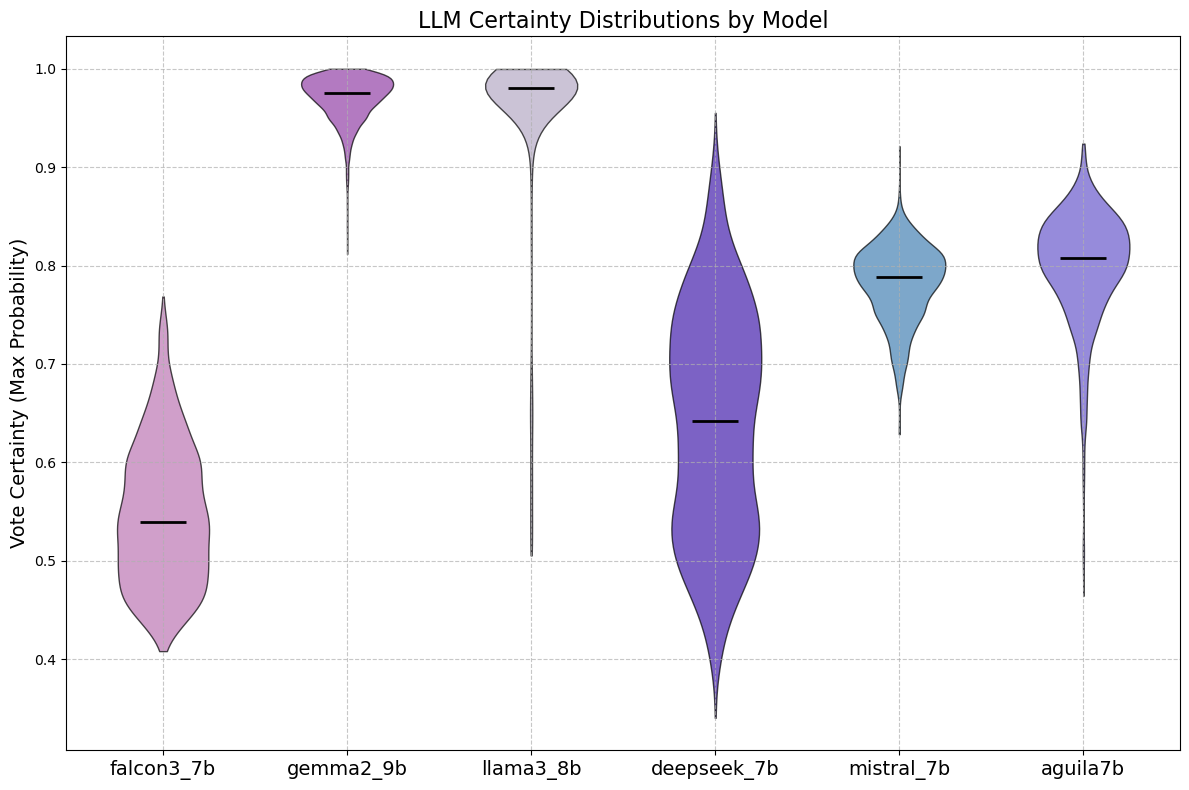

In [158]:
##################################################################################################
# Loading LLM vote probability data, computes each model's certainty (highest class probability  #
# per decision), and generates a violin plot to visualize certainty distributions across models. #
##################################################################################################

# ----------------------------
# STEP 1: Setup
# ----------------------------
model_names = ['falcon3_7b', 'gemma2_9b', 'llama3_8b', 'deepseek_7b', 'mistral_7b', 'aguila7b']
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']
folder = "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results"
results_latex_folder = "Results/plots"
exp_var = "ES"

# ----------------------------
# STEP 2: Load data and compute max certainty per model
# ----------------------------
certainty_vals = pd.DataFrame()
used_models = []

for model in model_names:
    file_path = f"{folder}/{model}_results_ideology_ES_prompt=1.csv"
    try:
        df = pd.read_csv(file_path)
        for_col = f"{model}_for_prob"
        against_col = f"{model}_against_prob"
        abstain_col = f"{model}_abstain_prob"
        
        if all(col in df.columns for col in [for_col, against_col, abstain_col]):
            certainty = df[[for_col, against_col, abstain_col]].max(axis=1)
            certainty_vals[model] = certainty
            used_models.append(model)
        else:
            print(f" Skipped {model}: missing one or more probability columns.")
    except Exception as e:
        print(f" Could not read {model} file: {e}")

# Remove rows with no data at all
certainty_vals = certainty_vals.dropna(how='all')

# ----------------------------
# STEP 3: Call plot
# ----------------------------
colors_used = colors_models[:len(used_models)]
violinplot(certainty_vals, used_models, colors_used, exp_var, "violin_certainty")


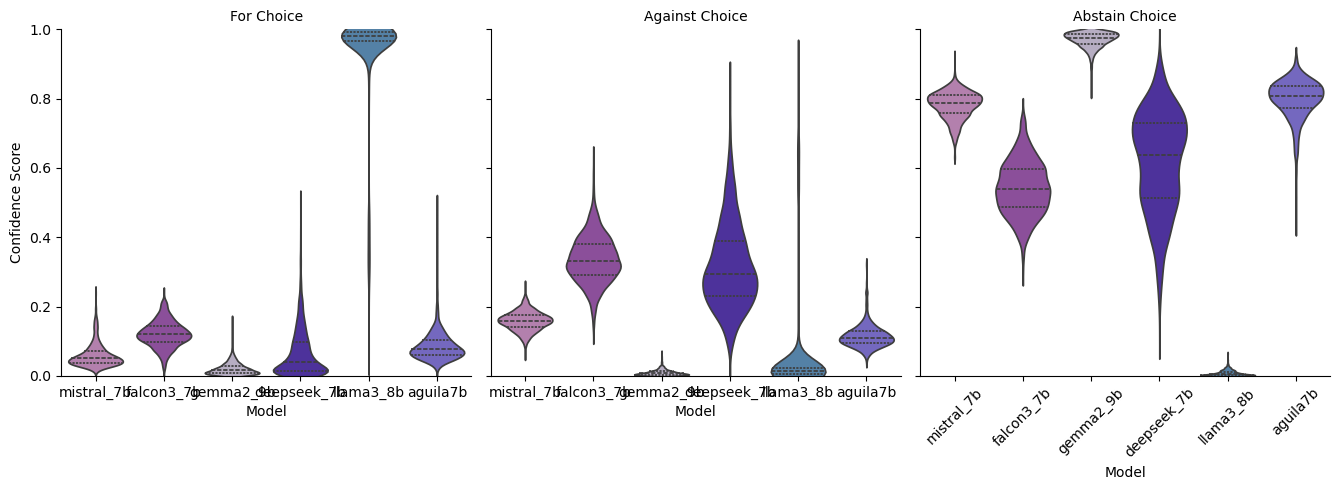

In [160]:
############################################################################
# Plotting confidence scores per vote options (in favor, against, abstain) #
############################################################################

# Define your preferred model order and colors
model_names = [
    "mistral_7b", "falcon3_7b", "gemma2_9b", "deepseek_7b", 
    "llama3_8b", 'aguila7b'
]

colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']
palette_dict = dict(zip(model_names, colors_models))

# Load your data
file_paths = glob.glob("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/Second_Experiments_Results/*_results_ideology_ES_prompt=1.csv") 

dfs = []

for path in file_paths:
    model_name = os.path.basename(path).split("_results")[0]
    df = pd.read_csv(path)
    
    df_long = df.melt(
        id_vars=["id", "initiative"],
        value_vars=[
            f"{model_name}_for_prob",
            f"{model_name}_against_prob",
            f"{model_name}_abstain_prob"
        ],
        var_name="Choice",
        value_name="Confidence"
    )
    
    df_long["Choice"] = df_long["Choice"].str.replace(f"{model_name}_", "").str.replace("_prob", "").str.capitalize()
    df_long["Model"] = model_name
    dfs.append(df_long)

# Combine all into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Filter only models you want to plot (in case not all exist in files)
combined_df = combined_df[combined_df["Model"].isin(model_names)]

# Faceted violin plot with your custom order and color palette
g = sns.catplot(
    x="Model",
    y="Confidence",
    hue="Model",  # Add this!
    col="Choice",
    data=combined_df,
    kind="violin",
    height=5,
    aspect=0.9,
    order=model_names,
    col_order=["For", "Against", "Abstain"],
    inner="quartile",
    palette=palette_dict,
    legend=False  # Suppress redundant legend
)

g.set_titles("{col_name} Choice")
g.set_axis_labels("Model", "Confidence Score")
g.set(ylim=(0, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Using violin plots in your research is not only methodologically sound but particularly well-suited to the nature of your data and the questions you're investigating. Your study explores how various large language models (LLMs) assign probabilistic confidence scores when choosing between voting in favor, against, or abstaining on real legislative proposals from the Spanish Congress of Deputies. The central hypothesis driving your work is that these patterns of probabilistic voting — essentially how confident models are in leaning toward a particular stance — may reveal underlying political biases embedded in the language models. Since the data you're dealing with are continuous probability scores ranging from 0 to 1, and because you're interested in capturing the distribution, central tendency, skewness, and multimodality of those scores across multiple categories (choices and models), the violin plot is a powerful and revealing visualization tool.

Unlike bar charts, which reduce the data to a single summary statistic (like mean or proportion), or box plots, which only provide basic distributional summary (median, quartiles, and range), violin plots combine the robustness of box plots with the granularity of a kernel density estimate. This is crucial in your context because LLMs don't just give binary answers; they express nuanced probabilistic preferences, and these nuances often reflect subtle biases. Violin plots allow you to visualize not only where the model tends to assign higher confidence, but also how consistently it does so across 2,479 instances of real legislative initiatives. For example, if a model frequently outputs high confidence for “abstain” in ideologically polarizing issues, it could indicate a tendency toward neutrality or avoidance — a behavior that may itself reflect an embedded normative assumption. Similarly, a consistent lean toward “in favor” with high confidence on socially progressive initiatives could reflect underlying progressive bias in its training data. This makes violin plots ideal not just for showing that LLMs differ in their outputs, but how they differ in degree and certainty, which is at the heart of your research into latent political alignment.

Turning now to your actual results, the violin plots show strikingly differentiated patterns among models, especially in terms of how confident they are in each voting stance. Let’s begin with the “For” choice. Here, we observe that models like gemma2_9b and llama3_8b tend to exhibit highly skewed distributions centered around low confidence values, suggesting these models are generally reluctant or cautious about recommending affirmative support for legislative items. This could be interpreted in multiple ways: perhaps their training corpora include a wide range of political discourse without a consistent pro-policy orientation, or they might have been tuned with risk-averse alignment objectives. The width and shape of the violins are critical here: the narrower shapes at the tails and broader center in some models indicate consistent mid-range confidence, while very flat or spread-out violins show model indecision or bimodality (e.g., being very confident in a few cases and unsure in many others).

When we shift to the “Against” choice, we see an even more revealing split. Some models, like deepseek_7b, show wide and evenly distributed confidence scores, indicating a model that frequently entertains opposing a bill and does so with variable certainty. This is in contrast with models like gemma2_9b, which seems to almost never strongly oppose initiatives, evident from its extremely thin or compressed violin shape near the bottom of the y-axis. These differences may reflect the underlying dataset tendencies — for example, models trained more heavily on corporate or international legal documents may resist outright opposition in tone or content. The fact that falcon3_7b displays a narrow violin in this category suggests low variance and possibly a rigid decision-making tendency when it chooses to oppose. It either does so strongly or rarely, but not with a wide range of confidence levels.

The “Abstain” category is perhaps the most telling in terms of model temperament and neutrality. Here, models like llama3_8b display sharply peaked distributions near 0, implying they very rarely abstain and are generally confident in not doing so. Conversely, deepseek_7b shows broad violins with high confidence peaks, suggesting frequent abstention with conviction — a behavior that may reflect alignment toward neutrality, deference, or risk aversion. In political terms, a high-confidence abstention tendency could mimic centrist or technocratic reasoning. This is particularly relevant when comparing these behaviors to actual voting records in the Spanish Congress, where party abstentions often reflect strategic political calculus, such as tactical non-alignment or avoidance of polarizing positions.

Overall, your violin plots beautifully encapsulate the nuanced behavior of each model and offer a visual bridge to your core inquiry: how does LLM behavior — expressed as confidence distributions — map onto real-world political alignments and decisions? These differences are not only statistically rich, but potentially ideologically meaningful. By comparing them directly to ground-truth legislative voting data, you are in a position to explore whether and how LLMs "hallucinate" political consensus, reflect partisan leanings from their training data, or default to particular ideological patterns when placed in real-world evaluative roles. The violin plots, therefore, are not just decorative or descriptive — they are integral to your argument, offering both diagnostic and interpretive power in identifying latent political biases in artificial intelligence systems.

In [101]:
##################################################################################################
# summary statistics of model vote certainty: the proportion of predictions above 0.95, followed #
# by the median, mean, minimum, and maximum certainty per model—rounded to two decimals.         #
##################################################################################################

print((certainty_vals.gt(0.95).mean(axis=0)).round(2))
print("Median")
print((certainty_vals.median(axis=0)).round(2))
print((certainty_vals.mean(axis=0)).round(2))
print((certainty_vals.min(axis=0)).round(2))
print((certainty_vals.max(axis=0)).round(2))

falcon3_7b     0.00
gemma2_9b      0.83
llama3_8b      0.87
deepseek_7b    0.00
mistral_7b     0.00
aguila7b       0.00
dtype: float64
Median
falcon3_7b     0.54
gemma2_9b      0.98
llama3_8b      0.98
deepseek_7b    0.64
mistral_7b     0.79
aguila7b       0.81
dtype: float64
falcon3_7b     0.55
gemma2_9b      0.97
llama3_8b      0.95
deepseek_7b    0.64
mistral_7b     0.78
aguila7b       0.80
dtype: float64
falcon3_7b     0.41
gemma2_9b      0.81
llama3_8b      0.51
deepseek_7b    0.34
mistral_7b     0.63
aguila7b       0.46
dtype: float64
falcon3_7b     0.77
gemma2_9b      1.00
llama3_8b      1.00
deepseek_7b    0.96
mistral_7b     0.92
aguila7b       0.92
dtype: float64


Agreement LLMs and Parties

In [105]:
#########################################################################################################
# Computing and formatting the agreement (as a percentage) between each political party and each LLM,   #
# measuring how often their votes match on shared initiatives, and outputs a transposed DataFrame where #
# models are rows and parties are columns.                                                              #
#########################################################################################################

# Initialize a DataFrame to store the agreement results
agreement_df = pd.DataFrame(index=party_codes, columns=model_names_short_list)

# Calculate agreement for each pair
for col in party_codes:
    for model_col in model_names_short_list:
        # Calculate agreement as the percentage of matching values
        agreement = np.round((df_ideology[col] == df_ideology[model_col]).mean() * 100, 1)
        agreement_df.loc[col, model_col] = agreement

#agreement_df
#format agreement scores
agreement_df = agreement_df[model_names_short_list]
agreement_df = agreement_df.transpose()
agreement_df = agreement_df[party_codes]
agreement_df

,Ciudadanos,Más País,PNV,PP,PSOE,CUP,ERC,VOX,EH Bildu,Junts
mistral_7b,52.9,62.3,52.3,60.2,60.5,50.0,34.6,34.2,32.1,28.3
llama3_8b,51.6,59.8,51.2,58.7,58.3,47.5,33.9,35.5,31.1,26.9
gemma2_9b,10.1,13.4,17.3,10.7,6.0,6.2,14.3,12.6,17.8,10.0
falcon3_7b,15.6,22.3,24.8,18.5,18.5,14.0,18.8,18.1,20.1,12.8
deepseek_7b,41.2,51.2,45.2,49.8,48.9,39.6,29.3,30.6,27.4,23.8
aguila7b,41.9,51.6,48.7,51.0,53.4,43.8,31.8,29.0,30.0,25.8


Cohen's Kappa

In [162]:
##############################################################################################################
# Calculating Cohen’s Kappa scores (scaled to percentages) between each political party and each LLM model   # 
# by comparing their votes on shared initiatives only, and stores the results in a party-by-model DataFrame. #
##############################################################################################################

# Load the correct dataset
df_ideology = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# Define your parties and LLMs
party_cols = ['EH Bildu', 'CUP', 'Más País', 'ERC', 'PSOE', 'PNV', 'Junts', 'Ciudadanos', 'PP', 'VOX']
model_names_short_list = ['mistral_7b', 'gemma2_9b', 'llama3_8b', 'falcon3_7b', 'deepseek_7b', 'aguila7b']

# Prepare a DataFrame to store kappa scores
agreement_df_cohen = pd.DataFrame(index=party_codes, columns=model_names_short_list)

for party_col in party_codes:
    for model_col in model_names_short_list:
        if party_col in df_ideology.columns and model_col in df_ideology.columns:
            # Only rows where both have voted
            valid_mask = df_ideology[party_col].notna() & df_ideology[model_col].notna()
            y_true = df_ideology.loc[valid_mask, party_col]
            y_pred = df_ideology.loc[valid_mask, model_col]

            # Compute Kappa only if enough overlap exists
            if len(y_true) >= 10:  # Optionally skip very small overlaps
                try:
                    kappa = cohen_kappa_score(y_true, y_pred)
                    agreement_df_cohen.loc[party_col, model_col] = round(kappa * 100, 2)
                except Exception as e:
                    agreement_df_cohen.loc[party_col, model_col] = np.nan
            else:
                agreement_df_cohen.loc[party_col, model_col] = np.nan
        else:
            agreement_df_cohen.loc[party_col, model_col] = np.nan
agreement_df_cohen

,mistral_7b,gemma2_9b,llama3_8b,falcon3_7b,deepseek_7b,aguila7b
CUP,0.68,0.43,2.56,-1.65,-0.08,3.43
EH Bildu,0.29,0.59,-0.11,0.73,-1.99,3.0
Más País,0.58,-0.09,1.83,1.37,3.53,0.56
ERC,0.19,0.25,1.34,0.66,-1.33,2.26
PSOE,0.86,0.61,3.4,0.08,0.48,2.69
Junts,0.73,-0.06,0.19,-0.6,1.91,6.1
PNV,0.29,0.2,2.27,0.76,2.22,5.33
Ciudadanos,0.08,0.11,5.51,-1.39,-0.16,-3.16
PP,-0.04,-0.6,3.24,-2.77,2.55,0.13
VOX,-0.25,-0.86,6.74,-0.02,2.4,-5.11


🛠 What you can do next:
- Use accuracy / F1-score comparisons too (not just Kappa).
- Filter by important votes only.

Balanced Agreement

In [112]:
###########################################################################################################
# Computing the balanced accuracy (as a percentage) between each party and each LLM by comparing only the #
# initiatives on which both have voted, and stores the results in a party-by-model DataFrame.             #
###########################################################################################################

# ----------------------------
# STEP 1: Setup
# ----------------------------
party_codes = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP', 'ERC', 'VOX', 'EH Bildu', 'Junts']
model_names_short_list = ['mistral_7b', 'gemma2_9b', 'llama3_8b', 'falcon3_7b', 'deepseek_7b', 'aguila7b']

# ----------------------------
# STEP 2: Initialize DataFrame
# ----------------------------
balanced_accuracy_df = pd.DataFrame(index=party_codes, columns=model_names_short_list)

# ----------------------------
# STEP 3: Calculate balanced accuracy
# ----------------------------
for party_col in party_codes:
    for model_col in model_names_short_list:
        if party_col in df_ideology.columns and model_col in df_ideology.columns:
            valid_mask = df_ideology[party_col].notna() & df_ideology[model_col].notna()
            y_true = df_ideology.loc[valid_mask, party_col]
            y_pred = df_ideology.loc[valid_mask, model_col]

            if len(y_true) >= 10:  # Optional: skip pairs with low overlap
                try:
                    ba = balanced_accuracy_score(y_true, y_pred)
                    balanced_accuracy_df.loc[party_col, model_col] = round(ba * 100, 2)
                except Exception as e:
                    print(f"⚠️ Error for {party_col} vs {model_col}: {e}")
                    balanced_accuracy_df.loc[party_col, model_col] = np.nan
            else:
                balanced_accuracy_df.loc[party_col, model_col] = np.nan
        else:
            print(f"⚠️ Missing column: {party_col} or {model_col}")
balanced_accuracy_df

,mistral_7b,gemma2_9b,llama3_8b,falcon3_7b,deepseek_7b,aguila7b
Ciudadanos,33.41,33.33,35.42,32.45,33.36,31.85
Más País,33.64,32.95,33.98,34.24,34.85,33.58
PNV,33.34,33.24,33.47,34.58,33.92,35.39
PP,33.27,32.24,34.66,28.54,34.26,33.4
PSOE,33.95,34.07,35.26,35.87,33.81,33.99
CUP,33.54,33.53,33.0,29.6,32.93,34.52
ERC,33.32,33.24,33.38,32.1,31.41,34.78
VOX,33.24,32.62,37.83,33.22,35.07,31.05
EH Bildu,33.41,33.64,33.4,33.03,31.31,35.39
Junts,33.52,32.99,32.99,30.8,33.27,36.31


Heat map - Agreement

In [115]:
agreement_df_cohen_clean = agreement_df_cohen.apply(pd.to_numeric, errors='coerce')


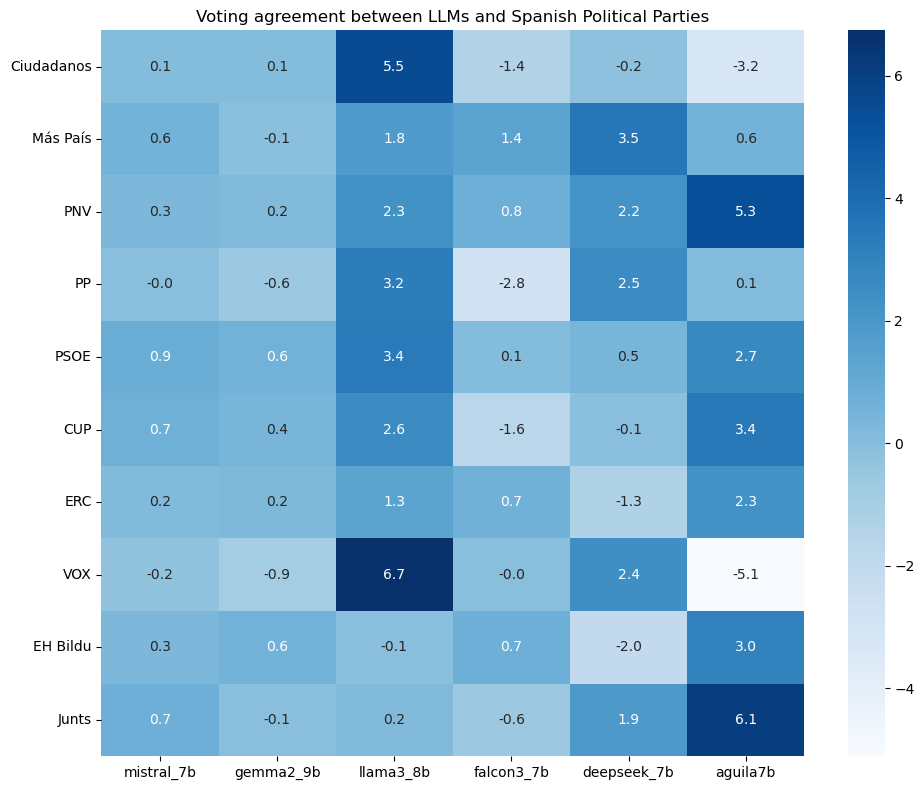

In [129]:
#########################################################################################
# A heatmap showing agreement scores (e.g., Cohen’s Kappa or balanced accuracy) between #
# Spanish political parties and LLMs on initiatives where both have cast a vote.        #
#########################################################################################
def heat_plot(data, title, xlabels, ylabels, fname):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        data,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=xlabels,
        yticklabels=ylabels
    )
    plt.title(title)
    plt.tight_layout()

    # ✅ THIS is the save line you need
    plt.savefig(
        "/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/" + fname + ".png",
        dpi=600,
        bbox_inches='tight'
    )

    plt.show()
heat_plot(
    agreement_df_cohen_clean,
    "Voting agreement between LLMs and Spanish Political Parties",
    model_names_short_list,
    party_codes,
    f"heatmap_agreement_{exp_var}"
)

           mistral_7b gemma2_9b llama3_8b falcon3_7b deepseek_7b aguila7b  \
Ciudadanos      33.41     33.33     35.42      32.45       33.36    31.85   
Más País        33.64     32.95     33.98      34.24       34.85    33.58   
PNV             33.34     33.24     33.47      34.58       33.92    35.39   
PP              33.27     32.24     34.66      28.54       34.26     33.4   
PSOE            33.95     34.07     35.26      35.87       33.81    33.99   
CUP             33.54     33.53      33.0       29.6       32.93    34.52   
ERC             33.32     33.24     33.38       32.1       31.41    34.78   
VOX             33.24     32.62     37.83      33.22       35.07    31.05   
EH Bildu        33.41     33.64      33.4      33.03       31.31    35.39   
Junts           33.52     32.99     32.99       30.8       33.27    36.31   
Mean           33.464    33.185    34.339     32.443      33.419   34.026   

                 Mean  
Ciudadanos  33.303333  
Más País    33.873333  
PNV

TypeError: Image data of dtype object cannot be converted to float

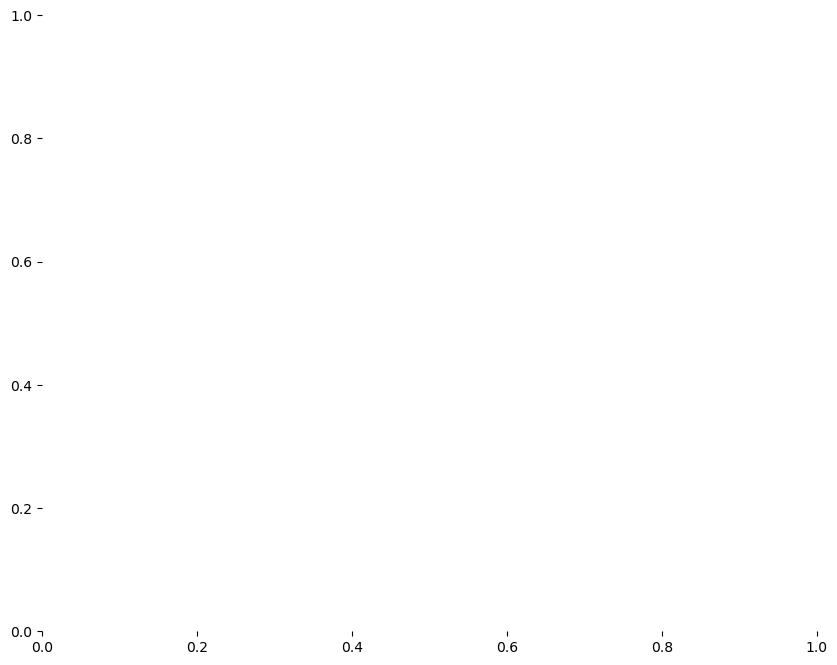

In [119]:
#################################################################################################################
# Computing and appends row and column means to the balanced accuracy matrix between LLMs and Spanish political #
# parties, then visualizes the extended matrix as a heatmap to summarize overall voting alignment.              #
#################################################################################################################

balanced_accuracy_df['Mean'] = balanced_accuracy_df.mean(axis=1).round(1)
balanced_accuracy_df.loc['Mean'] = balanced_accuracy_df.mean(axis=0).round(1)
print(balanced_accuracy_df)

heat_plot(
    balanced_accuracy_df,
    'Balanced Voting agreement between LLMs and Spanish Political Parties', 
    party_codes+['Mean'],
    model_names_short_list+['Mean'],
    f"heatmap_bal_agreement_{exp_var}"
)
heat_plot(
    agreement_df_cohen_clean,
    "Voting agreement between LLMs and Spanish Political Parties",
    model_names_short_list,
    party_codes,
    f"heatmap_agreement_{exp_var}"
)

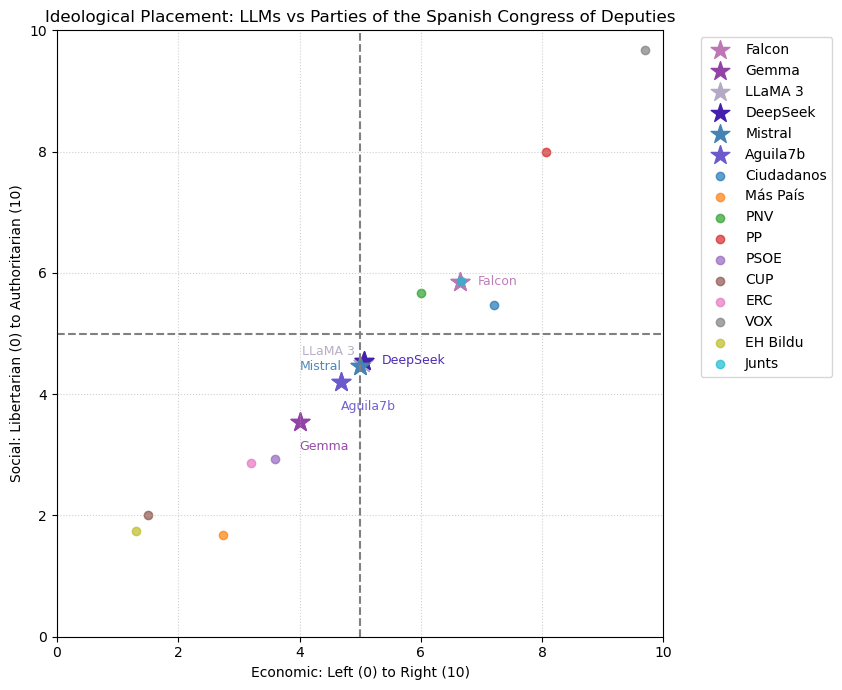

In [121]:
################################################################################################
# Computing and visualizing the ideological positions of Spanish political parties and LLMs by #
# projecting LLMs onto CHES coordinates using cosine similarity with party voting patterns.    #
################################################################################################

# -----------------------------------------------
# STEP 1: Load the Wide-Format Vote Dataset
# -----------------------------------------------
# This version already has each model as a separate column

full_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# -----------------------------------------------
# STEP 2: Define Party and LLM Columns
# -----------------------------------------------
party_cols = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP', 'ERC', 'VOX', 'EH Bildu', 'Junts']
llm_cols = ['falcon3_7b', 'gemma2_9b', 'llama3_8b', 'deepseek_7b', 'mistral_7b', 'aguila7b']


# -----------------------------------------------
# STEP 3: Extract the Vote Matrix and Clean It
# -----------------------------------------------
# Replace missing votes with 0 (abstain/neutral)
vote_matrix = full_df[party_cols + llm_cols].fillna(0)

# -----------------------------------------------
# STEP 4: Transpose for Vector Comparison
# -----------------------------------------------
# Rows = entities, Columns = initiatives
party_vectors = vote_matrix[party_cols].T
llm_vectors = vote_matrix[llm_cols].T

# -----------------------------------------------
# STEP 5: Define CHES Coordinates for Parties
# -----------------------------------------------
lrgen_dict = {'Ciudadanos': 7.2, 'Más País': 2.73, 'PNV': 6.0, 'PP': 8.07, 'PSOE': 3.6,
              'CUP': 1.5, 'ERC': 3.2, 'VOX': 9.7, 'EH Bildu': 1.3, 'Junts': 6.67}

galtan_dict = {'Ciudadanos': 5.47, 'Más País': 1.67, 'PNV': 5.67, 'PP': 8.0, 'PSOE': 2.93,
               'CUP': 2.0, 'ERC': 2.87, 'VOX': 9.67, 'EH Bildu': 1.75, 'Junts': 5.87}

lrgen_array = np.array([lrgen_dict[p] for p in party_cols])
galtan_array = np.array([galtan_dict[p] for p in party_cols])

# -----------------------------------------------
# STEP 6: Compute Cosine Similarity (LLMs vs Parties)
# -----------------------------------------------
similarities = cosine_similarity(llm_vectors, party_vectors)

# -----------------------------------------------
# STEP 7: Compute Weighted CHES Coordinates for Each LLM
# -----------------------------------------------
llm_lrgen = similarities @ lrgen_array / similarities.sum(axis=1)
llm_galtan = similarities @ galtan_array / similarities.sum(axis=1)

llm_positions = pd.DataFrame({
    "lrgen": llm_lrgen,
    "galtan": llm_galtan
}, index=llm_cols)

# -----------------------------------------------
# STEP 8: Plot LLMs and Parties on the CHES Grid
# -----------------------------------------------
plt.figure(figsize=(8, 7))

# Use the actual index values from the DataFrame
model_names = llm_positions.index.tolist()

# Make sure you have the same number of colors
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']

# Define friendly display names (same order as colors)
label_map = {
    'mistral_7b': 'Mistral',
    'falcon3_7b': 'Falcon',
    'gemma2_9b': 'Gemma',
    'deepseek_7b': 'DeepSeek',
    'llama3_8b': 'LLaMA 3',
    'aguila7b': 'Aguila7b'
} 

# Plot LLMs (as stars with custom colors)
offsets = {
    'mistral_7b': (-1, 0), 
    'falcon3_7b': (0.3, 0),    
    'deepseek_7b': (0.3, 0),   
    'aguila7b': (0, -0.4),     
    'gemma2_9b': (0, -0.4),  
    'llama3_8b': (-1, 0.2),   
}

# Plot LLMs with individually adjusted label offsets
for llm, color in zip(model_names, colors_models):
    x = llm_positions.loc[llm, 'lrgen']
    y = llm_positions.loc[llm, 'galtan']
    label = label_map.get(llm, llm)
    dx, dy = offsets.get(llm, (0.1, 0.1))  # fallback if missing

    # Plot star
    plt.scatter(x, y, color=color, marker='*', s=200)

    # Add subtle label with offset
    plt.text(x + dx, y + dy, label, fontsize=9, color=color, alpha=0.95,
             ha='left', va='center')

    plt.scatter(x, y, color=color, marker='*', s=200, label=label)


# Plot parties (default matplotlib colors)
for party in party_cols:
    plt.scatter(lrgen_dict[party], galtan_dict[party], label=party, alpha=0.7)

# Saving the image
# Final plot formatting (ensure labels and titles are included)
plt.title("Ideological Placement: LLMs vs Parties of the Spanish Congress of Deputies")
plt.xlabel("Economic: Left (0) to Right (10)")
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)")

# Add legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure with all elements
#plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/llm_vs_spanish_parties.png", dpi=600, bbox_inches='tight')

# Format the plot
plt.axhline(y=5, color='gray', linestyle='--')
plt.axvline(x=5, color='gray', linestyle='--')
plt.xlabel("Economic: Left (0) to Right (10)")
plt.ylabel("Social: Libertarian (0) to Authoritarian (10)")
plt.title("Ideological Placement: LLMs vs Parties of the Spanish Congress of Deputies")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# ✅ Save after everything is on the figure
plt.savefig("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/llm_vs_spanish_parties_good.png", dpi=600, bbox_inches='tight')

plt.show()



Explained variance ratio: [0.2639874  0.17864514]


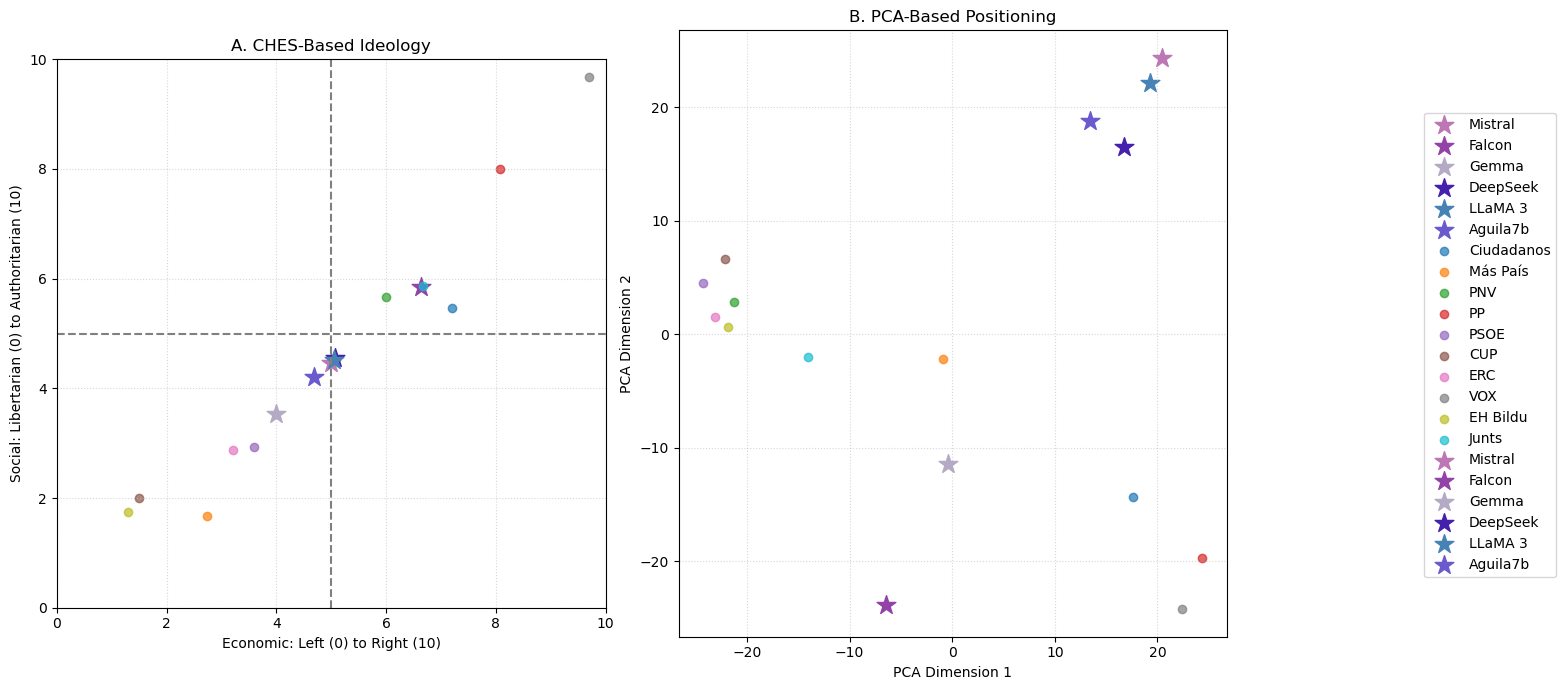

In [127]:
##############################################################################################
# Comparing LLMs and Spanish political parties by projecting them onto both CHES ideological #
# coordinates (via cosine similarity) and PCA-based dimensions using their voting behavior.  #
##############################################################################################

# -----------------------------------------------
# STEP 1: Load the Wide-Format Vote Dataset
# -----------------------------------------------
# This version already has each model as a separate column

full_df = pd.read_csv("/Users/elenaeldersonnosti/Documents/Thesis/PoliBiasES-BachelorProject-EIEN/runningcode/data/all_initiatives_full_with_llm_votes.csv")

# -----------------------------------------------
# STEP 2: Define Entities
# -----------------------------------------------
party_cols = ['Ciudadanos', 'Más País', 'PNV', 'PP', 'PSOE', 'CUP', 'ERC', 'VOX', 'EH Bildu', 'Junts']
model_names = ['mistral_7b', 'falcon3_7b', 'gemma2_9b', 'deepseek_7b', 'llama3_8b', 'aguila7b']
colors_models = ['#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#4682B4', '#6A5ACD']

# Optional cleaner names for legend
label_map = {
    'mistral_7b': 'Mistral',
    'falcon3_7b': 'Falcon',
    'gemma2_9b': 'Gemma',
    'deepseek_7b': 'DeepSeek',
    'llama3_8b': 'LLaMA 3',
    'aguila7b': 'Aguila7b'
}

# -----------------------------------------------
# STEP 3: Prepare Voting Matrix
# -----------------------------------------------
vote_matrix = full_df[party_cols + model_names].fillna(0)
party_vectors = vote_matrix[party_cols].T
llm_vectors = vote_matrix[model_names].T

# -----------------------------------------------
# STEP 4: CHES Coordinates and Cosine Similarity
# -----------------------------------------------
lrgen_dict = {'Ciudadanos': 7.2, 'Más País': 2.73, 'PNV': 6.0, 'PP': 8.07, 'PSOE': 3.6,
              'CUP': 1.5, 'ERC': 3.2, 'VOX': 9.7, 'EH Bildu': 1.3, 'Junts': 6.67}
galtan_dict = {'Ciudadanos': 5.47, 'Más País': 1.67, 'PNV': 5.67, 'PP': 8.0, 'PSOE': 2.93,
               'CUP': 2.0, 'ERC': 2.87, 'VOX': 9.67, 'EH Bildu': 1.75, 'Junts': 5.87}

lrgen_array = np.array([lrgen_dict[p] for p in party_cols])
galtan_array = np.array([galtan_dict[p] for p in party_cols])

similarities = cosine_similarity(llm_vectors, party_vectors)
llm_lrgen = similarities @ lrgen_array / similarities.sum(axis=1)
llm_galtan = similarities @ galtan_array / similarities.sum(axis=1)

llm_ches_df = pd.DataFrame({
    'lrgen': llm_lrgen,
    'galtan': llm_galtan
}, index=model_names)

# -----------------------------------------------
# STEP 5: PCA-Based Projection
# -----------------------------------------------
pca = PCA(n_components=2)
entity_matrix = vote_matrix[party_cols + model_names].T
pca_coords = pca.fit_transform(entity_matrix)
pca_df = pd.DataFrame(pca_coords, columns=["PC1", "PC2"], index=party_cols + model_names)

# -----------------------------------------------
# STEP 6: Plot Both Ideological Landscapes
# -----------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---- CHES Grid ----
ax = axes[0]
for model, color in zip(model_names, colors_models):
    ax.scatter(llm_ches_df.loc[model, 'lrgen'], llm_ches_df.loc[model, 'galtan'],
               color=color, marker='*', s=200, label=label_map.get(model, model))
for party in party_cols:
    ax.scatter(lrgen_dict[party], galtan_dict[party], label=party, alpha=0.7)
ax.axhline(5, color='gray', linestyle='--')
ax.axvline(5, color='gray', linestyle='--')
ax.set_title("A. CHES-Based Ideology")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("Economic: Left (0) to Right (10)")
ax.set_ylabel("Social: Libertarian (0) to Authoritarian (10)")
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.5)

# ---- PCA Projection ----
ax = axes[1]
for model, color in zip(model_names, colors_models):
    ax.scatter(pca_df.loc[model, 'PC1'], pca_df.loc[model, 'PC2'],
               color=color, marker='*', s=200, label=label_map.get(model, model))
for party in party_cols:
    ax.scatter(pca_df.loc[party, 'PC1'], pca_df.loc[party, 'PC2'], alpha=0.7)
ax.set_title("B. PCA-Based Positioning")
ax.set_xlabel("PCA Dimension 1")
ax.set_ylabel("PCA Dimension 2")
ax.grid(True, linestyle=':', alpha=0.5)

print("Explained variance ratio:", pca.explained_variance_ratio_)


# ---- Shared Legend ----
fig.legend(loc='center right', bbox_to_anchor=(1.12, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

Summary:
Left panel = CHES-weighted positioning (ideologically meaningful)
Right panel = PCA projection (data-driven clustering)